Dataset [link](https://can01.safelinks.protection.outlook.com/?url=https%3A%2F%2Fdrive.google.com%2Fdrive%2Ffolders%2F1-6sd6E3cL8uWdNeO4xiXxLbTSYXSTiVr%3Fusp%3Dsharing&data=04%7C01%7Carash.gholami%40queensu.ca%7C92b180b5b67d475fb70e08d87b7f4305%7Cd61ecb3b38b142d582c4efb2838b925c%7C1%7C0%7C637395133804367020%7CUnknown%7CTWFpbGZsb3d8eyJWIjoiMC4wLjAwMDAiLCJQIjoiV2luMzIiLCJBTiI6Ik1haWwiLCJXVCI6Mn0%3D%7C1000&sdata=1ieR3E8llMblC0QMBtx1%2FpHS71RQuCxzdNQLmH0HJVU%3D&reserved=0)

Explanation: There are **49** users' data here. Naming is in the format of Username_ExperimentNumber. Please also note that it is unprocessed raw data, which includes a lot of noise etc. 

Experiment-1: **20** participants are involved in this task and the participants were asked to type **a story** from **a set** of short and simple stories from the American Literature https://americanliterature.com/100-great-short-stories for **four minutes**. The story was chosen randomly by the participants.

Experiment-2: 20 participants are involved in this task and for this data set, all the participants were asked to type the **same text** https://en.wikipedia.org/wiki/The_Adventures_of_Tom_Sawyer for **four minutes**. For each participant, almost the same amount of data is collected as Experiment-1. This dataset is important to be able to measure the quality of the features. The collection of this dataset is quite realistic since in a real case the users could be also asked to type a given text during their CA sessions. 

Experiment-3: The participants are asked to type **10 different pangram sentences**. Pangrams sentences contain** all 26 letters** of the alphabet. This data set is used to test how the **letter distribution** of text affects the result.

Experiment-4: **34** participants are involved in this task and the participants were instructed to imitate someone else's typing pattern by watching the prerecorded video of the other person. For these experiments, one of the participants was recorded on video while typing a short and simple sentence for **15 seconds** from a perspective that the hand motions, smartwatch, keyboard, and the screen could be seen. Although it was not required, the perspective allowed to infer what the victim was typing by watching. This dataset was primarily used to analyze the **attacking scenarios**. It is left to the participant to type the exact same text or imitate the hand movement of the victim.

-----------------------

I realized that you have mostly 4s and 10s as values on column A, but I also found 2s. What does column A represent? 
A represents the sensor type:
 
**10 for the accelerometer
4 for the gyroscope**
2 for the magnetic field sensor

You can find more info about sensors and constant values that are used to define the sensor type in these links:
- https://developer.android.com/guide/topics/sensors/sensors_overview
- https://developer.android.com/reference/android/hardware/Sensor#TYPE_LINEAR_ACCELERATION

Normally, I only collected and used accelerometer and gyroscope sensor data. Magnetometer data should not be in the dataset. If there is, that means it is an **outlier**.
 
Is column B the time stamp, is it recorded at 100HZ?

In an android app, you can set the sampling rate "SENSOR_DELAY_NORMAL, SENSOR_DELAY_UI, SENSOR_DELAY_GAME, or SENSOR_DELAY_FASTEST " 

As far as I remember I used **"SENSOR_DELAY_FASTEST" for all sensors**, but in practice, I had a lot of issues regarding this. They **don't give a constant sampling rate**. Every time I used they were giving different sampling rates. They were giving different sampling rates for two sessions of the same user, for different users, or for different sensors. Therefore, I would recommend using the one in the practice, which you can calculate using the timestamp and the sample count. 

On the paper you said you have recorded both accelerometer and gyro data; but you seem to only have one of them at a time on columns C, D, and F. I am guessing 10 on column A represents accelerometer and 4 gyro, but I could be wrong. 
Also, some rows have more columns, and start with 11 on column A. What do those represent?
Please see the explanation above. 
 

In short, I would really appreciate it if you could let me know information I need to know for working with the data.

Also, as these sensors were giving me a lot of headaches because they are really not stable, I needed to perform a lot of preprocessing. I **cleaned the outliers** before further processing. I also applied some other filtering techniques such as **moving average** to obtain more smooth data. Moreover, I needed to **clean the part the users are not performing typing operation from the beginning and end**, which you can see if you plot the values, i.e., the **user stops meaning no value and then big deviations, where the user takes off the smartwatch**.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

CORES = -1
SEED = 567

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

utility_functions imports setup complete
Python 3.9.10
EER: 0.333, Threshold: 0.600 <-- Arbitrary case
EER: 0.000, Threshold: 0.900 <-- Best case
EER: 1.000, Threshold: 0.900 <-- Worse case
EER: 0.400, Threshold: 0.200 <-- Worse case


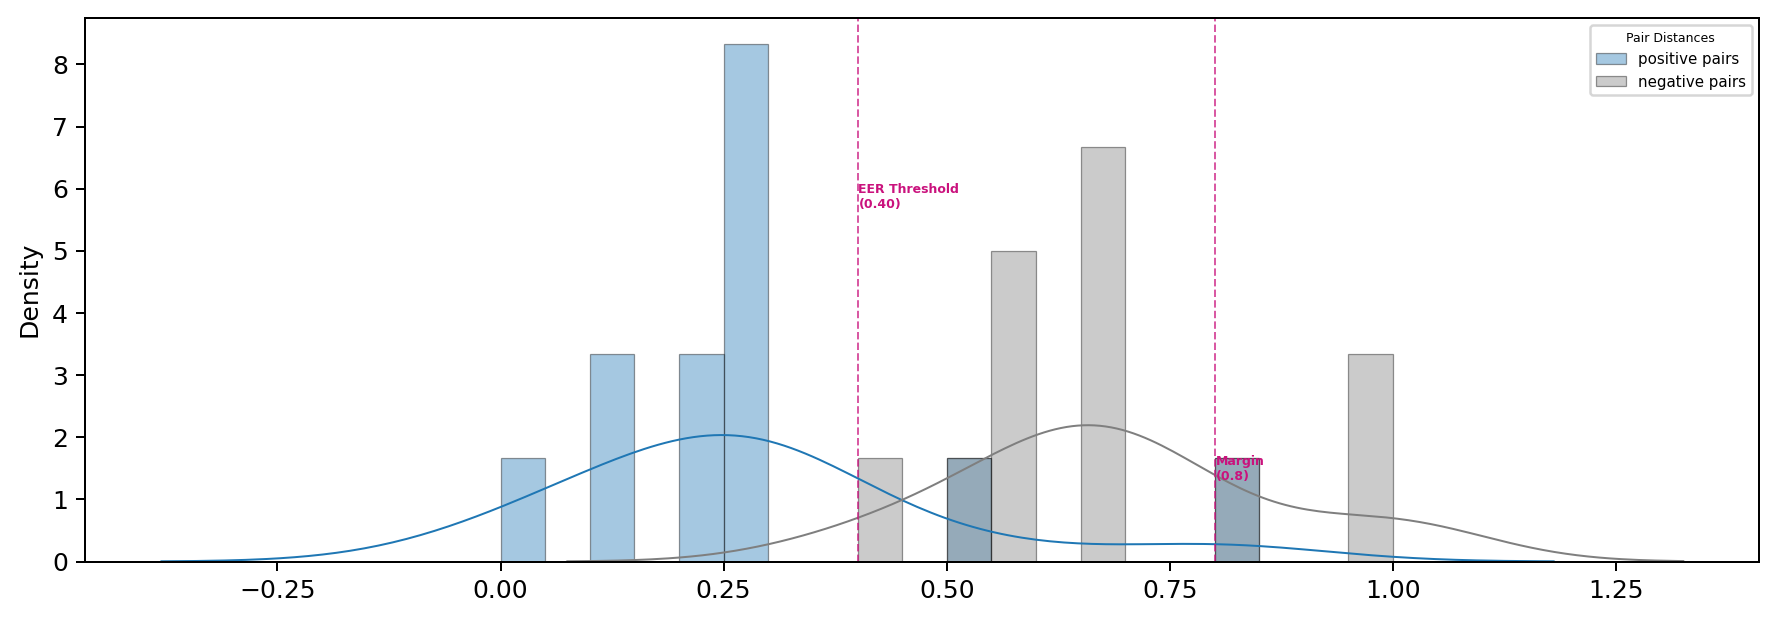

utility functions imported
Seed was set to: 567
Setup Complete


In [2]:
# !pip install --upgrade pip
# !pip install python-docx
# !pip install antropy


from joblib import Parallel, delayed


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dataclasses
import math as math
from sklearn.svm import OneClassSVM
from sklearn.model_selection import cross_validate, RandomizedSearchCV
import statsmodels.stats.api as sms
from tqdm.auto import tqdm
from dataclasses import asdict
from sklearn import svm
from tqdm import tqdm
import warnings
import random
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, accuracy_score, make_scorer, auc
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold # Feature selector
from sklearn.model_selection import KFold
from sklearn import metrics
# import tensorflow as tfw
from keras import backend as K
from keras.models import Model
from keras.layers import (
    Dense,
    Input,
    Conv1D,
    MaxPooling1D,
    Flatten,
    Lambda,
    Conv2D,
    MaxPooling2D,
    Dropout,
    BatchNormalization,
    GlobalAveragePooling1D,
    Activation
)
from keras.utils.vis_utils import plot_model
from tensorflow.keras.optimizers import Adam, SGD,RMSprop
from keras.models import load_model
from keras.callbacks import Callback


import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import iqr
from scipy.stats import median_absolute_deviation
from scipy.stats import mode
from scipy.signal import find_peaks
from scipy.signal import peak_widths
# from scipy.special import entr
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, MaxAbsScaler, RobustScaler, PowerTransformer
get_new_scaler_dict = {"StandardScaler": StandardScaler, "MinMaxScaler": MinMaxScaler, "Normalizer": Normalizer, 
                       "MaxAbsScaler": MaxAbsScaler, "RobustScaler": RobustScaler, "PowerTransformer": PowerTransformer}
from sklearn.preprocessing import normalize
from sklearn.metrics import auc
# import antropy as ant
import time
# import docx

# Global utitlity functions are in separate notebook
# jupyter nbconvert --to script 'my-notebook.ipynb'
%run ./utility-functions.ipynb
# %run ./utility-functions.py


np.random.seed(SEED)
print(f"Seed was set to: {SEED}")

print("Setup Complete")

In [3]:
@dataclasses.dataclass
class ExperimentParameters:
    """Contains all relevant parameters to run an experiment."""

    name: str  # Name of Experiments Parameter set. Used as identifier for charts etc.

    # Data / Splitting:
    frequency: int
    feature_cols: list  # Columns used as features
    max_subjects: int
    user_ids: list
    num_sample_points_per_exp: int
    exp_begin_cutoff_idx: int
    exp_end_cutoff_idx: int
        
#     exclude_subjects: list  # Don't load data from those users
    n_valid_train_subjects: int
    n_valid_test_subjects: int
    n_test_train_subjects: int
    n_test_test_subjects: int
    seconds_per_subject_train: float
    seconds_per_subject_test: float
    task_types: list  # Limit scenarios to [1, 3, 5] for sitting or [2, 4, 6] for walking, or don't limit (None)

    # Reshaping
    window_size: int  # After resampling
    nn_step_width: int
    ocsvm_step_width: int

    # Normalization
    scaler: str  # {"std", "robust", "minmax"}
    scaler_scope: str  # {"subject", "session"}
    scaler_global: bool  # scale training and testing sets at once (True), or fit scaler on training only (False)

    # Siamese Network
    max_pairs_per_session: int  # Max. number of pairs per session
    margin: float  # Contrastive Loss Margin
    model_variant: str  # {"1d", "2d"} Type of architecture
    filters: list  # List of length 4, containing number of filters for conv layers
    epochs_best: int  # Train epochs to for final model
    epochs_max: int
    batch_size: int
    optimizer: str  # Optimizer to use for Siamese Network
    optimizer_lr: float  # Learning Rate
    optimizer_decay: float

    # OCSVM
    ocsvm_kernel: str # ocsvm kernel
    ocsvm_nu: float  # Best value found in random search, used for final model
    ocsvm_gamma: float  # Best value found in random search, used for final model

    # Calculated values
    def __post_init__(self):
        # HDF key of table:
        self.table_name = f"sensors_{self.frequency}hz"

        # Number of samples per _session_ used for training:
        self.samples_per_subject_train = math.ceil(
            (self.seconds_per_subject_train * 100)
            / (100 / self.frequency)
            / self.window_size
        )

        # Number of samples per _session_ used for testing:
        self.samples_per_subject_test = math.ceil(
            (self.seconds_per_subject_test * 100)
            / (100 / self.frequency)
            / self.window_size
        )


# INSTANCES
# ===========================================================

# NAIVE_MINMAX (2D Filters)
# -----------------------------------------------------------
NAIVE_MINMAX_2D = ExperimentParameters(
    name="NAIVE-MINMAX-2D",
#     # Data / Splitting
    frequency=100,
    feature_cols=[
        "acc_x",
        "acc_y",
        "acc_z",
        "gyr_x",
        "gyr_y",
        "gyr_z"
    ],
    max_subjects=29,
    user_ids = [1, 2, 3, 4, 5, 6, 7, 8, 19, 21, 22, 26, 27, 28, 29, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49],
    num_sample_points_per_exp=21000,
    exp_begin_cutoff_idx=500,
    exp_end_cutoff_idx=-500,
    n_valid_train_subjects=40,
    n_valid_test_subjects=10,
    n_test_train_subjects=10,
    n_test_test_subjects=30,
    seconds_per_subject_train=67.5,
    seconds_per_subject_test=67.5,
    task_types=None,
    # Reshaping
    window_size=100 * 1,  #1 sec
    nn_step_width=125,
    ocsvm_step_width=125,
    # Normalization
    scaler="minmax",
    scaler_scope="subject",
    scaler_global=True,
    # Siamese Network
    model_variant="2d",
    filters=[32, 64, 128, 32],
#     filters=[32, 64, 128, 64],
    epochs_best=35,
    epochs_max=40,
    batch_size=200,
    optimizer="sgd",
    optimizer_lr=0.01,
    optimizer_decay=0,
    max_pairs_per_session=60,  # => 4min
    margin=0.2,
    # OCSVM
    ocsvm_kernel="rbf",
    ocsvm_nu=0.092,
    ocsvm_gamma=1.151,
)  # <END NAIVE_APPROACH>

# VALID_MINMAX (2D)
# -----------------------------------------------------------
VALID_MINMAX_2D = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-MINMAX-2D",
    task_types=None,
    scaler_global=False,
    epochs_max=40,
    ocsvm_nu=0.110,
    ocsvm_gamma=59.636,
)

# NAIVE_ROBUST (2D)
# -----------------------------------------------------------
NAIVE_ROBUST_2D = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="NAIVE-ROBUST-2D",
    scaler="robust",
    optimizer="sgd",
    optimizer_lr=0.05, # Decreased, to avoid "all zeros" prediction
    optimizer_decay=0.002,
    epochs_best=5,
    ocsvm_nu=0.214,
    ocsvm_gamma=2.354,
)

# VALID_ROBUST (2D)
# -----------------------------------------------------------
VALID_ROBUST_2D = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-ROBUST-2D",
    scaler="robust",
    scaler_global=False,
    epochs_best=6,
    epochs_max=20,
    optimizer="sgd",
    optimizer_lr=0.05,  # Decrease LR, to avoid "all zeros" prediction
    optimizer_decay=0.002,
    ocsvm_nu=0.190,
    ocsvm_gamma=0.069,
)

# VALID_ROBUST (1D)
# -----------------------------------------------------------
VALID_ROBUST_1D = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-ROBUST-1D",
    scaler="robust",
    scaler_global=False,
    model_variant="1d", 
    filters=[32, 64, 128, 64],    
    epochs_best=9,
    epochs_max=20,
    ocsvm_nu=0.156,
    ocsvm_gamma=33.932,
)

# FCN_ROBUST (1D)
# -----------------------------------------------------------
VALID_FCN_ROBUST_125 = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-FCN-ROBUST-FINAL",
    task_types=[1, 2],
    feature_cols=["acc_x", "acc_y", "acc_z", 'gyr_x', 'gyr_y', 'gyr_z'], 
    frequency=100,
    window_size=125,

    scaler="RobustScaler",
    scaler_global=False,
    seconds_per_subject_train=60 * 10,
    seconds_per_subject_test=60 * 10,
    max_pairs_per_session=60 * 10,
    model_variant="fcn",
    filters=[32, 64, 32],
    optimizer="adam",
    optimizer_lr=0.00001,
#     optimizer_lr=0.0001,
#     optimizer_lr=0.001,
#     optimizer_lr=0.01,
    optimizer_decay=None,
    batch_size=300,
    margin=1,
#     margin=.2,
    epochs_best=40,
    epochs_max=80,
    ocsvm_nu=0.007,
    ocsvm_gamma=0.002,
)

VALID_FCN_ROBUST_250 = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-FCN-ROBUST-FINAL",
    task_types=[1, 2],
    feature_cols=["acc_x", "acc_y", "acc_z", 'gyr_x', 'gyr_y', 'gyr_z'], 
    frequency=100,
    window_size=250,

    scaler="RobustScaler",
    scaler_global=False,
    seconds_per_subject_train=60 * 10,
    seconds_per_subject_test=60 * 10,
    max_pairs_per_session=60 * 10,
    model_variant="fcn",
    filters=[32, 64, 32],
    optimizer="adam",
    optimizer_lr=0.00001,
#     optimizer_lr=0.0001,
#     optimizer_lr=0.001,
#     optimizer_lr=0.01,
    optimizer_decay=None,
    batch_size=300,
    margin=1,
#     margin=.2,
    epochs_best=40,
    epochs_max=80,
    ocsvm_nu=0.007,
    ocsvm_gamma=0.002,
)

VALID_FCN_ROBUST_500 = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-FCN-ROBUST-FINAL",
    task_types=[1, 2],
    feature_cols=["acc_x", "acc_y", "acc_z", 'gyr_x', 'gyr_y', 'gyr_z'], 
    frequency=100,
    window_size=500,

    scaler="RobustScaler",
    scaler_global=False,
    seconds_per_subject_train=60 * 10,
    seconds_per_subject_test=60 * 10,
    max_pairs_per_session=60 * 10,
    model_variant="fcn",
    filters=[32, 64, 32],
    optimizer="adam",
    optimizer_lr=0.00001,
#     optimizer_lr=0.0001,
#     optimizer_lr=0.001,
#     optimizer_lr=0.01,
    optimizer_decay=None,
    batch_size=300,
    margin=1,
#     margin=.2,
    epochs_best=40,
    epochs_max=80,
    ocsvm_nu=0.007,
    ocsvm_gamma=0.002,
)

VALID_FCN_ROBUST_750 = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-FCN-ROBUST-FINAL",
    task_types=[1, 2],
    feature_cols=["acc_x", "acc_y", "acc_z", 'gyr_x', 'gyr_y', 'gyr_z'], 
    frequency=100,
    window_size=750,

    scaler="RobustScaler",
    scaler_global=False,
    seconds_per_subject_train=60 * 10,
    seconds_per_subject_test=60 * 10,
    max_pairs_per_session=60 * 10,
    model_variant="fcn",
    filters=[32, 64, 32],
    optimizer="adam",
    optimizer_lr=0.00001,
#     optimizer_lr=0.0001,
#     optimizer_lr=0.001,
#     optimizer_lr=0.01,
    optimizer_decay=None,
    batch_size=300,
    margin=1,
#     margin=.2,
    epochs_best=40,
    epochs_max=80,
    ocsvm_nu=0.007,
    ocsvm_gamma=0.002,
)

VALID_FCN_ROBUST_1000 = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-FCN-ROBUST-FINAL",
    task_types=[1, 2],
    feature_cols=["acc_x", "acc_y", "acc_z", 'gyr_x', 'gyr_y', 'gyr_z'], 
    frequency=100,
    window_size=1000,

    scaler="RobustScaler",
    scaler_global=False,
    seconds_per_subject_train=60 * 10,
    seconds_per_subject_test=60 * 10,
    max_pairs_per_session=60 * 10,
    model_variant="fcn",
    filters=[32, 64, 32],
    optimizer="adam",
    optimizer_lr=0.00001,
#     optimizer_lr=0.0001,
#     optimizer_lr=0.001,
#     optimizer_lr=0.01,
    optimizer_decay=None,
    batch_size=300,
    margin=1,
#     margin=.2,
    epochs_best=40,
    epochs_max=80,
    ocsvm_nu=0.007,
    ocsvm_gamma=0.002,
)

VALID_FCN_ROBUST_1250 = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-FCN-ROBUST-FINAL",
    task_types=[1, 2],
    feature_cols=["acc_x", "acc_y", "acc_z", 'gyr_x', 'gyr_y', 'gyr_z'], 
    frequency=100,
    window_size=1250,

    scaler="RobustScaler",
    scaler_global=False,
    seconds_per_subject_train=60 * 10,
    seconds_per_subject_test=60 * 10,
    max_pairs_per_session=60 * 10,
    model_variant="fcn",
    filters=[32, 64, 32],
    optimizer="adam",
    optimizer_lr=0.00001,
#     optimizer_lr=0.0001,
#     optimizer_lr=0.001,
#     optimizer_lr=0.01,
    optimizer_decay=None,
    batch_size=300,
    margin=1,
#     margin=.2,
    epochs_best=40,
    epochs_max=80,
    ocsvm_nu=0.007,
    ocsvm_gamma=0.002,
)


VALID_FCN_ROBUST_1500 = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-FCN-ROBUST-FINAL",
    task_types=[1, 2],
    feature_cols=["acc_x", "acc_y", "acc_z", 'gyr_x', 'gyr_y', 'gyr_z'], 
    frequency=100,
    window_size=1500,

    scaler="RobustScaler",
    scaler_global=False,
    seconds_per_subject_train=60 * 10,
    seconds_per_subject_test=60 * 10,
    max_pairs_per_session=60 * 10,
    model_variant="fcn",
    filters=[32, 64, 32],
    optimizer="adam",
    optimizer_lr=0.00001,
#     optimizer_lr=0.0001,
#     optimizer_lr=0.001,
#     optimizer_lr=0.01,
    optimizer_decay=None,
    batch_size=300,
    margin=1,
#     margin=.2,
    epochs_best=40,
    epochs_max=80,
    ocsvm_nu=0.007,
    ocsvm_gamma=0.002,
)

VALID_FCN_ROBUST_1750 = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-FCN-ROBUST-FINAL",
    task_types=[1, 2],
    feature_cols=["acc_x", "acc_y", "acc_z", 'gyr_x', 'gyr_y', 'gyr_z'], 
    frequency=100,
    window_size=1750,

    scaler="RobustScaler",
    scaler_global=False,
    seconds_per_subject_train=60 * 10,
    seconds_per_subject_test=60 * 10,
    max_pairs_per_session=60 * 10,
    model_variant="fcn",
    filters=[32, 64, 32],
    optimizer="adam",
    optimizer_lr=0.00001,
#     optimizer_lr=0.0001,
#     optimizer_lr=0.001,
#     optimizer_lr=0.01,
    optimizer_decay=None,
    batch_size=300,
    margin=1,
#     margin=.2,
    epochs_best=40,
    epochs_max=80,
    ocsvm_nu=0.007,
    ocsvm_gamma=0.002,
)


VALID_FCN_ROBUST_2000 = dataclasses.replace(
    NAIVE_MINMAX_2D,
    name="VALID-FCN-ROBUST-FINAL",
    task_types=[1, 2],
    feature_cols=["acc_x", "acc_y", "acc_z", 'gyr_x', 'gyr_y', 'gyr_z'], 
    frequency=100,
    window_size=2000,

    scaler="RobustScaler",
    scaler_global=False,
    seconds_per_subject_train=60 * 10,
    seconds_per_subject_test=60 * 10,
    max_pairs_per_session=60 * 10,
    model_variant="fcn",
    filters=[32, 64, 32],
    optimizer="adam",
    optimizer_lr=0.00001,
#     optimizer_lr=0.0001,
#     optimizer_lr=0.001,
#     optimizer_lr=0.01,
    optimizer_decay=None,
    batch_size=300,
    margin=1,
#     margin=.2,
    epochs_best=40,
    epochs_max=80,
    ocsvm_nu=0.007,
    ocsvm_gamma=0.002,
)

In [6]:
P = VALID_FCN_ROBUST_750
# utils_ppp(P)
# P = VALID_ROBUST_1D
# utils_ppp(P)
# P = NAIVE_MINMAX_2D

In [7]:
P.nn_step_width = int(P.window_size * .5)
utils_ppp(P)

,Value
name,VALID-FCN-ROBUST-FINAL
frequency,100
feature_cols,"[acc_x, acc_y, acc_z, gyr_x, gyr_y, gyr_z]"
max_subjects,29
user_ids,"[1, 2, 3, 4, 5, 6, 7, 8, 19, 21, 22, 26, 27, 2..."
num_sample_points_per_exp,21000
exp_begin_cutoff_idx,500
exp_end_cutoff_idx,-500
n_valid_train_subjects,40
n_valid_test_subjects,10


### 1.4 Select Approach <a id='1.4'>&nbsp;</a> 
Select the parameters to use for current notebook execution here!

# Split Dataset for Valid/Test  
In two splits: one used during hyperparameter optimization, and one used during testing.

The split is done along the subjects: All sessions of a single subject will either be in the validation split or in the testing split, never in both.

They did a 30 60 split.

# Reshaping Raw Features.
We have our own function of windows for this. Do this for both training and testing.

# Extracting time and frequency based features.
Again, we have a function for this. Do this for both training and testing.

# Hyperparameter Optimization 

I do not find any reaqsonable explaination how to use a cross-validation as we are talking about anomaly detection.

I am using the experiment 1 data as train, and experiment 2 data as validation.

# Using SVM in a real-world Scenario with multiple genuine users and intruders
Source: https://datascience.stackexchange.com/questions/23623/what-is-the-best-way-to-classify-data-not-belonging-to-set-of-classes

Stage 1: 
    Use one-class SVM to assign those images that do not belong to the set of predefined classes as the 9-th class.

Stage 2:
    For those images that passes through your filter, let the multi-class SVM assign them to one of the 8 classes.

Loading data:

In [8]:
df_exps_dict = load_data_frames(P.user_ids, P.exp_begin_cutoff_idx, P.exp_end_cutoff_idx, P.num_sample_points_per_exp)
dfList_exp1, dfList_exp2 = df_exps_dict['dfList_exp1'], df_exps_dict['dfList_exp2']

Loading exp1 data:
1) accel_count: 28388, gyro_count: 31997


/tmp/ipykernel_74/1195744216.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_74/1195744216.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


2) accel_count: 26015, gyro_count: 28954
3) accel_count: 28227, gyro_count: 31814


/tmp/ipykernel_74/1195744216.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_74/1195744216.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


4) accel_count: 24862, gyro_count: 26103
5) accel_count: 24270, gyro_count: 24347


/tmp/ipykernel_74/1195744216.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_74/1195744216.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


6) accel_count: 25012, gyro_count: 25060
7) accel_count: 25301, gyro_count: 25382


/tmp/ipykernel_74/1195744216.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_74/1195744216.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


8) accel_count: 21985, gyro_count: 21658
19) accel_count: 24122, gyro_count: 25050


/tmp/ipykernel_74/1195744216.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_74/1195744216.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


21) accel_count: 24367, gyro_count: 23830
22) accel_count: 29284, gyro_count: 28863


/tmp/ipykernel_74/1195744216.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_74/1195744216.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


26) accel_count: 23148, gyro_count: 24291
27) accel_count: 24299, gyro_count: 23589


/tmp/ipykernel_74/1195744216.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_74/1195744216.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


28) accel_count: 23807, gyro_count: 24523
29) accel_count: 24030, gyro_count: 23475


/tmp/ipykernel_74/1195744216.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_74/1195744216.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


35) accel_count: 24388, gyro_count: 23673
36) accel_count: 24244, gyro_count: 24208


/tmp/ipykernel_74/1195744216.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_74/1195744216.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


37) accel_count: 32022, gyro_count: 31843
38) accel_count: 22138, gyro_count: 22327


/tmp/ipykernel_74/1195744216.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_74/1195744216.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


39) accel_count: 23573, gyro_count: 23459
40) accel_count: 23057, gyro_count: 24296


/tmp/ipykernel_74/1195744216.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_74/1195744216.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


41) accel_count: 24102, gyro_count: 23681
42) accel_count: 24074, gyro_count: 24328


/tmp/ipykernel_74/1195744216.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_74/1195744216.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


43) accel_count: 22631, gyro_count: 23835
44) accel_count: 24474, gyro_count: 23749


/tmp/ipykernel_74/1195744216.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_74/1195744216.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


45) accel_count: 23974, gyro_count: 23229
46) accel_count: 23614, gyro_count: 23827


/tmp/ipykernel_74/1195744216.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_74/1195744216.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


48) accel_count: 22828, gyro_count: 23904
49) accel_count: 24183, gyro_count: 24633
Loading exp2 data:


/tmp/ipykernel_74/1195744216.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_74/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


1) accel_count: 24049, gyro_count: 26943
2) accel_count: 24472, gyro_count: 27667


/tmp/ipykernel_74/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_74/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


3) accel_count: 24611, gyro_count: 27000
4) accel_count: 24972, gyro_count: 26798


/tmp/ipykernel_74/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_74/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


5) accel_count: 23573, gyro_count: 23372
6) accel_count: 23800, gyro_count: 23890


/tmp/ipykernel_74/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_74/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


7) accel_count: 23347, gyro_count: 24145
8) accel_count: 22964, gyro_count: 22660


/tmp/ipykernel_74/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_74/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


19) accel_count: 26160, gyro_count: 25846
21) accel_count: 23642, gyro_count: 24444


/tmp/ipykernel_74/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_74/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


22) accel_count: 23863, gyro_count: 24589
26) accel_count: 23179, gyro_count: 23925


/tmp/ipykernel_74/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_74/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


27) accel_count: 25121, gyro_count: 25829
28) accel_count: 23133, gyro_count: 24039


/tmp/ipykernel_74/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_74/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


29) accel_count: 23180, gyro_count: 24314
35) accel_count: 23299, gyro_count: 23854


/tmp/ipykernel_74/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_74/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


36) accel_count: 25500, gyro_count: 25059
37) accel_count: 25994, gyro_count: 25232


/tmp/ipykernel_74/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_74/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


38) accel_count: 21168, gyro_count: 21182
39) accel_count: 24214, gyro_count: 23585


/tmp/ipykernel_74/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_74/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


40) accel_count: 23944, gyro_count: 23170
41) accel_count: 23195, gyro_count: 24111


/tmp/ipykernel_74/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_74/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


42) accel_count: 26505, gyro_count: 25697
43) accel_count: 22692, gyro_count: 23982


/tmp/ipykernel_74/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_74/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


44) accel_count: 23002, gyro_count: 23829
45) accel_count: 23978, gyro_count: 23350


/tmp/ipykernel_74/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_74/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


46) accel_count: 21128, gyro_count: 21848
48) accel_count: 28000, gyro_count: 27205


/tmp/ipykernel_74/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_74/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


49) accel_count: 23071, gyro_count: 24129


In [21]:
raw_dfList_exp1 = dfList_exp1
raw_dfList_exp2 = dfList_exp2

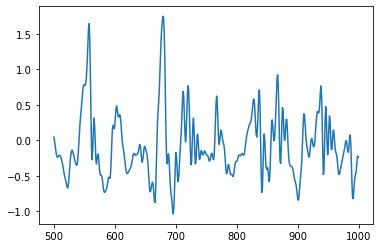

In [22]:
P.cut_off_freq=17
P.smoothing = "FFT"
ffted_dfList_exp1 = get_ffted_dfList(raw_dfList_exp1, cut_off_freq=P.cut_off_freq, filter_order=10)
ffted_dfList_exp2 = get_ffted_dfList(raw_dfList_exp2, cut_off_freq=P.cut_off_freq, filter_order=10)
ffted_dfList_exp2[0]['EMA_x_a'][500:1000].plot()
dfList_exp1 = ffted_dfList_exp1
dfList_exp2 = ffted_dfList_exp2

In [23]:
np.array(dfList_exp2[0]['EMA_x_a']).shape[0]

26943

In [24]:
randomized_data_idx = list(range(len(P.user_ids)))
random.Random(SEED).shuffle(randomized_data_idx)
split_idx = 2 * (len(randomized_data_idx)//3) + 1
train_set = randomized_data_idx[: split_idx]
test_set = randomized_data_idx[split_idx: ]
print(f"train_set: {train_set}\ntest_set: {test_set}")

train_set: [7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5]
test_set: [0, 12, 14, 9, 18, 23, 2, 15, 10, 4]


In [25]:
# preparing train data
# train_set = r
# dfList_exp1_train, dfList_exp2_train = [dfList_exp1[i] for i in train_set], [dfList_exp2[i] for i in train_set]
# print(f"len(dfList_exp1_train): {len(dfList_exp1_train)}")
# print(f"len(dfList_exp2_train): {len(dfList_exp2_train)}")
# XExpTrainDict = MakeXExpDic(dfList_exp1_train, dfList_exp2_train, window_size = 250, step = 251, numSamplePoints= 18000)
# X_exp1_train_dic, X_exp2_train_dic = XExpTrainDict["X_exp1_dic"], XExpTrainDict["X_exp2_dic"]

# # preparing test data
# dfList_exp1_test, dfList_exp2_test = [dfList_exp1[i] for i in test_set], [dfList_exp2[i] for i in test_set]
# print(f"len(dfList_exp1_test): {len(dfList_exp1_test)}")
# print(f"len(dfList_exp2_test): {len(dfList_exp2_test)}")
# XExpTestDict = MakeXExpDic(dfList_exp1_test, dfList_exp2_test, window_size = 250, step = 251, numSamplePoints= 18000)
# X_exp1_test_dic, X_exp2_test_dic = XExpTestDict["X_exp1_dic"], XExpTestDict["X_exp2_dic"]

# CNN

In [26]:
# preparing train data

# train_set = r
dfList_exp1_train, dfList_exp2_train = [dfList_exp1[i] for i in train_set], [dfList_exp2[i] for i in train_set]
print(f"len(dfList_exp1_train): {len(dfList_exp1_train)}")
print(f"len(dfList_exp2_train): {len(dfList_exp2_train)}")
# Raw_X_Exp_Train_Dict = MakeRawXExpDic(dfList_exp1_train, dfList_exp2_train, window_size=P.window_size, step=P.nn_step_width, numSamplePoints=P.num_sample_points_per_exp, 
#                                       scale_exp1=True, scale_exp2=True, scaler=P.scaler)
# ---- new, realistic way
Raw_X_Exp_Train_Dict = MakeRawXExpDic(dfList_exp1_train, dfList_exp2_train, window_size=P.window_size, step=P.nn_step_width, numSamplePoints=P.num_sample_points_per_exp, 
                                      scale_exp1=False, scale_exp2=True, scaler=P.scaler)

fitted_scaler_SNN_exp2_train_dic = Raw_X_Exp_Train_Dict["fitted_scaler_exp2_dic"]
# -----new
Raw_X_exp1_train_dic, Raw_X_exp2_train_dic = Raw_X_Exp_Train_Dict["Raw_X_exp1_dic"], Raw_X_Exp_Train_Dict["Raw_X_exp2_dic"]

# preparing test data
dfList_exp1_test, dfList_exp2_test = [dfList_exp1[i] for i in test_set], [dfList_exp2[i] for i in test_set]
print(f"len(dfList_exp1_test): {len(dfList_exp1_test)}")
print(f"len(dfList_exp2_test): {len(dfList_exp2_test)}")
Raw_X_Exp_Test_Dict = MakeRawXExpDic(dfList_exp1_test, dfList_exp2_test, window_size=P.window_size, step=P.ocsvm_step_width, numSamplePoints=P.num_sample_points_per_exp, 
                                     scale_exp1=False, scale_exp2=True, scaler=P.scaler)

fitted_scaler_ocsvm_exp2_dic = Raw_X_Exp_Test_Dict["fitted_scaler_exp2_dic"]
Raw_X_exp1_test_dic, Raw_X_exp2_test_dic = Raw_X_Exp_Test_Dict["Raw_X_exp1_dic"], Raw_X_Exp_Test_Dict["Raw_X_exp2_dic"]

len(dfList_exp1_train): 19
len(dfList_exp2_train): 19
user_idx: 0, exp_num: 2, scale: True, scaler: RobustScaler
(22964, 6)
user_idx: 1, exp_num: 2, scale: True, scaler: RobustScaler
(23829, 6)
user_idx: 2, exp_num: 2, scale: True, scaler: RobustScaler
(26160, 6)
user_idx: 3, exp_num: 2, scale: True, scaler: RobustScaler
(23925, 6)
user_idx: 4, exp_num: 2, scale: True, scaler: RobustScaler
(24039, 6)
user_idx: 5, exp_num: 2, scale: True, scaler: RobustScaler
(24214, 6)
user_idx: 6, exp_num: 2, scale: True, scaler: RobustScaler
(24129, 6)
user_idx: 7, exp_num: 2, scale: True, scaler: RobustScaler
(24111, 6)
user_idx: 8, exp_num: 2, scale: True, scaler: RobustScaler
(21848, 6)
user_idx: 9, exp_num: 2, scale: True, scaler: RobustScaler
(26798, 6)
user_idx: 10, exp_num: 2, scale: True, scaler: RobustScaler
(23944, 6)
user_idx: 11, exp_num: 2, scale: True, scaler: RobustScaler
(26505, 6)
user_idx: 12, exp_num: 2, scale: True, scaler: RobustScaler
(24145, 6)
user_idx: 13, exp_num: 2, scale: 

In [27]:
len(Raw_X_exp1_train_dic[0])

55

In [28]:
# dfList_exp1

In [29]:
# Raw_X_exp1_train_dic[0].shape

In [30]:
# dfList_exp1_test

In [31]:
# np.max(Raw_X_exp1_test_dic[0][0])

**Overview of current Experiment Parameters:**

#### Euclidead distance

In [32]:
def k_euclidean_dist(t):
    x = t[0]
    y = t[1]    
    return K.sqrt(K.sum(K.square(x - y), axis=-1, keepdims=True))

#### Loss Function

In [33]:
def k_contrastive_loss(y_true, dist):
    """Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """
    margin = P.margin
    return K.mean(y_true * K.square(dist) + (1 - y_true) * K.square(K.maximum(margin - dist, 0)))

In [34]:
def contrastive_loss_test(y_true, dist):
    """Test function above using implementation with numpy instead tensors."""
    margin = P.margin
    return y_true * np.square(dist) + (1 - y_true) * np.square(np.max(margin - dist, 0))

In [35]:
print("Positive: class=1, distance=0,     loss:", contrastive_loss_test(1, 0))
print("Positive: class=1, distance=0.01,  loss:", contrastive_loss_test(1, 0.01))
print("Positive: class=1, distance=0.3,   loss:", contrastive_loss_test(1, 0.3))
print("Positive: class=1, distance=0.5,   loss:", contrastive_loss_test(1, 0.5))
print("Positive: class=1, distance=1,     loss:", contrastive_loss_test(1, 1))

Positive: class=1, distance=0,     loss: 0
Positive: class=1, distance=0.01,  loss: 0.0001
Positive: class=1, distance=0.3,   loss: 0.09
Positive: class=1, distance=0.5,   loss: 0.25
Positive: class=1, distance=1,     loss: 1


In [36]:
print("Negative: class=0, distance=0,     loss:", contrastive_loss_test(0, 0))
print("Negative: class=0, distance=0.01,  loss:", contrastive_loss_test(0, 0.01))
print("Negative: class=0, distance=0.3,   loss:", contrastive_loss_test(0, 0.3))
print("Negative: class=0, distance=0.5,   loss:", contrastive_loss_test(0, 0.5))
print("Negative: class=0, distance=1,     loss:", contrastive_loss_test(0, 1))

Negative: class=0, distance=0,     loss: 1
Negative: class=0, distance=0.01,  loss: 0.9801
Negative: class=0, distance=0.3,   loss: 0.48999999999999994
Negative: class=0, distance=0.5,   loss: 0.25
Negative: class=0, distance=1,     loss: 0


#### Siamese Model with 2D Filters, as derived from Centeno et al. (2018)

In [37]:
# cite: Siamese Model with 2D Filters, as derived from Centeno et al. (2018)
# the thesis I found
def build_model_2d(input_shape, filters):
    """
        Siamese CNN architecture with 3D input and 2D filters
    """
    # Define the tensors for the two input images
    left_inputs = Input(input_shape, name="left_inputs")
    right_inputs = Input(input_shape, name="right_inputs")

    # Convolutional Neural Network
    inputs = Input(input_shape, name="input")
    x = Conv2D(filters[0], (7, 7), padding="same", activation="tanh", name="conv1")(inputs)
    x = MaxPooling2D(pool_size=(2, 2), padding="same", name="mp1")(x)
    x = Conv2D(filters[1], (5, 5), padding="same", activation="tanh", name="conv2")(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="same", name="mp2")(x)
    x = Conv2D(filters[2], (3, 3), padding="same", activation="tanh", name="conv3")(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="same", name="mp3")(x)
    x = Conv2D(filters[3], (3, 3), padding="same", activation="tanh", name="conv4")(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="same", name="mp4")(x)
    x = Flatten(name="flat")(x)
    
    # Basemodel instance
    basemodel = Model(inputs, x, name="basemodel")

    # using same instance of "basemodel" to share weights between left/right networks
    encoded_l = basemodel(left_inputs)
    encoded_r = basemodel(right_inputs)

    # Add a customized layer to compute the distance between the encodings
    distance_layer = Lambda(k_euclidean_dist, name="distance")([encoded_l, encoded_r])

    # Combine into one net
    siamese_net = Model(inputs=[left_inputs, right_inputs], outputs=distance_layer)

    # return the model
    return siamese_net, basemodel

#### Siamese Model with 1D Filters, as derived from Centeno et al. (2018)

In [38]:
def build_model_1d(input_shape, filters):
    """
        Model architecture
    """
    # Define the tensors for the two input images
    left_inputs = Input(input_shape, name="left_inputs")
    right_inputs = Input(input_shape, name="right_inputs")

    # Convolutional Neural Network
    inputs = Input(input_shape, name="input")
    x = Conv1D(filters[0], 7, activation="elu", padding="same", name="conv1")(inputs)
    x = MaxPooling1D(pool_size=2, name="mp1")(x)
    x = Conv1D(filters[1], 5, activation="elu", padding="same", name="conv2")(x)
    x = MaxPooling1D(pool_size=2, name="mp2")(x)
    x = Conv1D(filters[2], 3, activation="elu", padding="same", name="conv3")(x)
    x = MaxPooling1D(pool_size=2, name="mp3")(x)
    x = Conv1D(filters[3], 3, activation="elu", padding="same", name="conv4")(x)
    x = MaxPooling1D(pool_size=2, name="mp5")(x)
    x = Flatten(name="flat")(x)

    # Generate the encodings (feature vectors) for the two images
    basemodel = Model(inputs, x, name="basemodel")

    # using same instance of "basemodel" to share weights between left/right networks
    encoded_l = basemodel(left_inputs)
    encoded_r = basemodel(right_inputs)

    # Add a customized layer to compute the absolute difference between the encodings
    distance_layer = Lambda(k_euclidean_dist, name="distance")([encoded_l, encoded_r])

    siamese_net = Model(inputs=[left_inputs, right_inputs], outputs=distance_layer)

    # return the model
    return siamese_net, basemodel

In [197]:
P.filters

[32, 64, 32]

#### Siamese Model with FCN architecture

In [39]:
def build_model_fcn(input_shape, filters):
    # Define the tensors for the two input images
    left_inputs = Input(input_shape, name="left_inputs")
    right_inputs = Input(input_shape, name="right_inputs")

    # Convolutional Neural Network
    inputs = Input(input_shape, name="input")
    x = Conv1D(filters=filters[0], kernel_size=8, strides=1, activation=None, padding="same", name="conv1")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.1, name="drop1")(x)
    x = Conv1D(filters=filters[1], kernel_size=5, strides=1, activation=None, padding="same", name="conv2")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.1, name="drop2")(x)
    x = Conv1D(filters=filters[2], kernel_size=3, strides=1, activation=None, padding="same", name="conv3")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = GlobalAveragePooling1D()(x)
    # x = Dense(32, activation="sigmoid", name="dense")(x) # <--- !!!!!!!!!!!!
#     x = Dense(64, activation="sigmoid", name="dense")(x) # <--- !!!!!!!!!!!!
    x = Dense(78, activation="sigmoid", name="dense")(x)

    # Basemodel instance
    basemodel = Model(inputs, x, name="basemodel")

    # using same instance of "basemodel" to share weights between left/right networks
    encoded_l = basemodel(left_inputs)
    encoded_r = basemodel(right_inputs)

    # Add a customized layer to compute the distance between the encodings
    distance_layer = Lambda(k_euclidean_dist, name="distance")([encoded_l, encoded_r])

    # Combine into one net
    siamese_net = Model(inputs=[left_inputs, right_inputs], outputs=distance_layer)

    # return the model
    return siamese_net, basemodel

In [40]:
def get_model(name, window_size, feature_cols, filters):
    print(f"Using Model variant {name}...")
    if name == "1d":
        model, basemodel = build_model_1d((window_size, len(feature_cols)), filters)
    elif name == "2d":
        model, basemodel = build_model_2d((window_size, len(feature_cols), 1), filters)
    elif name == "fcn":
        model, basemodel = build_model_fcn((window_size, len(feature_cols)), filters)
    else:
        raise BaseException("Error: Not a valid model name: {1d, 2d, fcn}")

    return model, basemodel

In [41]:
def get_optimizer(name, lr=None, decay=None):
    if name == "sgd":
        lr = lr if lr != None else 0.01
        decay = decay if decay != None else 0
        optimizer = SGD(learning_rate=lr, decay=decay)
    elif name == "adam":
        lr = lr if lr != None else 0.001
        decay = decay if decay != None else 0
        optimizer = Adam(learning_rate=lr, decay=decay)
    elif name == "rmsprop":
        lr = lr if lr != None else 0.001
        optimizer = RMSprop(learning_rate=lr)
    else:
        raise BaseException("Error: Not a valid model name: 1d or 2d.")
    return optimizer

#### Inspect Model Architecture

In [42]:
temp_model, temp_basemodel = get_model(P.model_variant, P.window_size, P.feature_cols, P.filters)

temp_basemodel.summary()
temp_model.summary()

Using Model variant fcn...
Model: "basemodel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 750, 6)]          0         
_________________________________________________________________
conv1 (Conv1D)               (None, 750, 32)           1568      
_________________________________________________________________
batch_normalization (BatchNo (None, 750, 32)           128       
_________________________________________________________________
activation (Activation)      (None, 750, 32)           0         
_________________________________________________________________
drop1 (Dropout)              (None, 750, 32)           0         
_________________________________________________________________
conv2 (Conv1D)               (None, 750, 64)           10304     
_________________________________________________________________
batch_normalization_1 (Batch (

2022-06-21 05:09:47.461730: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-21 05:09:47.910689: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43675 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:65:00.0, compute capability: 8.6


In [43]:
# from itertools import product
import numpy as np
# c = list(product(a, b))
a1 = [1, 2, 5, 6]
a2 = [1, 2, 5, 6]
# a2 = [11,22,33,44]
# a2 = [3, 4, 5]
mesh = np.array(np.meshgrid(a1, a2))
print(mesh)
mesh = mesh.T.reshape(-1, 2)
print(mesh)
# print(np.array([mesh[:, 1], mesh[:, 0]]).T) good for u1u2 or u2u1 reversing the generated pairs
mesh = mesh.reshape(4,4,2)

print(mesh)
def deleteDiagonal(array):
    depth = array.shape[-1]
    m = array.shape[1]
    strided = np.lib.stride_tricks.as_strided
    s0,s1,s2 = array.strides
    return strided(array.ravel()[depth:], shape=(m-1, m, depth), strides=(s0+s1,s1, s2)).reshape(m, m-1, depth)
print(mesh.shape)
deleteDiagonal(mesh).reshape(12,2)

[[[1 2 5 6]
  [1 2 5 6]
  [1 2 5 6]
  [1 2 5 6]]

 [[1 1 1 1]
  [2 2 2 2]
  [5 5 5 5]
  [6 6 6 6]]]
[[1 1]
 [1 2]
 [1 5]
 [1 6]
 [2 1]
 [2 2]
 [2 5]
 [2 6]
 [5 1]
 [5 2]
 [5 5]
 [5 6]
 [6 1]
 [6 2]
 [6 5]
 [6 6]]
[[[1 1]
  [1 2]
  [1 5]
  [1 6]]

 [[2 1]
  [2 2]
  [2 5]
  [2 6]]

 [[5 1]
  [5 2]
  [5 5]
  [5 6]]

 [[6 1]
  [6 2]
  [6 5]
  [6 6]]]
(4, 4, 2)


array([[1, 2],
       [1, 5],
       [1, 6],
       [2, 1],
       [2, 5],
       [2, 6],
       [5, 1],
       [5, 2],
       [5, 6],
       [6, 1],
       [6, 2],
       [6, 5]])

In [44]:
def generate_negative_index_pairs(diagonal_size):
    '''
    return an array of indices for negative pairs for user u1 and u2, where u1 != u2
    u1 is the genuine user and u2 is the imposter.
    '''
    indices = list(range(diagonal_size))
    mesh = np.array(np.meshgrid(indices, indices))
    negative_index_pairs = mesh.T.reshape(-1, 2)
    
    return negative_index_pairs

def generate_positive_index_pairs(diagonal_size):
    '''
    return an array of tuple indices for the positive pairs.
    '''
    indices = list(range(diagonal_size))
    mesh = np.array(np.meshgrid(indices, indices))
    positive_index_pairs = mesh.T.reshape(-1, 2)
    positive_index_pairs = positive_index_pairs.reshape(diagonal_size, diagonal_size, 2)

    new_array_size = diagonal_size * diagonal_size - diagonal_size

    positive_index_pairs = deleteDiagonal(positive_index_pairs).reshape(new_array_size, 2)
    return positive_index_pairs

def generate_pairs(X_exp2_dic, X_exp1_dic, fitted_raw_scaler_dict=None, num_pair_limit = 50000):
    '''
    return positive and negative pairs
    '''
    num_users = len(X_exp2_dic)
    # print(num_users)
#     X_neg[np.random.choice(X_neg.shape[0], size=X_pos.shape[0], replace=False), :]
    negative_pairs_dic = {}
    positive_pairs_dic = {}
    
    total_samples_per_user = len(X_exp2_dic[list(X_exp2_dic.keys())[0]])
    # print(total_samples_per_user)
    positive_pairs_indices = generate_positive_index_pairs(total_samples_per_user)
    negative_pairs_indices = generate_negative_index_pairs(total_samples_per_user)
    
    positive_left = positive_pairs_indices[:, 0]
    positive_right = positive_pairs_indices[:, 1]
    
    negative_left = negative_pairs_indices[:, 0]
    negative_right = negative_pairs_indices[:, 1]
    # fitted_scaler_SNN_exp2_train_dic
    # print(positive_pairs_indices.shape)
    # print(negative_pairs_indices.shape)
    
    total_num_pairs = positive_pairs_indices.shape[0] * num_users * 2
    if num_pair_limit < total_num_pairs: 
        limit_ratio = num_pair_limit/total_num_pairs
    else:
        limit_ratio=1
            
    
    neg_fraction =  ((total_samples_per_user-1) / (total_samples_per_user * (num_users-1)))  # works accurate
    # neg_fraction =  (total_samples_per_user-1) / (total_samples_per_user * (num_users)) # works accurate
    for owner_key in tqdm(X_exp2_dic):
        # debugging was: X_exp2_dic is not an array, but needs to be an array if we want integer indexing. This can be changed in utility_functions; however, need to modify other code. 
        # print(type(positive_left))
        # print(len(X_exp2_dic[owner_key]))
        # print(np.array(X_exp2_dic[owner_key])[positive_left])
        
        # transform_user_windows(X_exp_unknown_df_dict[unknown_user], fitted_raw_scaler_dict[owner_key])
        u1_array = np.array(X_exp2_dic[owner_key])
        u2_array = np.array(transform_user_windows(X_exp1_dic[owner_key], fitted_raw_scaler_dict[owner_key]))
        positive_pairs_dic[owner_key] = np.array(list(zip(u1_array[positive_left], u2_array[positive_right])))
        
        new_pos_size = int(np.round(limit_ratio * positive_pairs_dic[owner_key].shape[0]))
        positive_pairs_dic[owner_key] = positive_pairs_dic[owner_key][np.random.choice(
                    positive_pairs_dic[owner_key].shape[0], size=new_pos_size, replace=False), :]
        
        for u2_key in X_exp2_dic:
            
            
            # should i eliminate less informative pairs like (w_n, w_m) vs (w_m, w_n)?
            if u2_key != owner_key:
                u2_array = np.array(transform_user_windows(X_exp1_dic[u2_key], fitted_raw_scaler_dict[owner_key]))
                negative_pairs_dic[(owner_key, u2_key)] = np.array(list(zip(u1_array[negative_left], u2_array[negative_right])))
                
                new_neg_size = int(np.round(negative_pairs_dic[(owner_key, u2_key)].shape[0] * neg_fraction * limit_ratio))
                negative_pairs_dic[(owner_key, u2_key)] = negative_pairs_dic[(owner_key, u2_key)][np.random.choice(
                    negative_pairs_dic[(owner_key, u2_key)].shape[0], size=new_neg_size, replace=False), :]
    # print(new_pos_size)
    # print(new_neg_size)
    return {"positive_pairs_dic": positive_pairs_dic, "negative_pairs_dic": negative_pairs_dic}

In [45]:
# lim = 2000
# for total_samples_per_user in [27]:
#     for num_users in [7, 10, 12, 15, 17, 20]:
        
        
#         print(generate_negative_index_pairs(total_samples_per_user).shape)
#         num_pos_per_owner = generate_positive_index_pairs(total_samples_per_user).shape[0]
#         total_num_pairs = num_pos_per_owner * num_users * 2
#         if lim < total_num_pairs: 
#             limit_ratio = lim/total_num_pairs
#         else:
#             limit_ratio=1
#         num_pos_per_owner = np.round(limit_ratio * num_pos_per_owner)
        
#         ratio = ((total_samples_per_user-1) / (total_samples_per_user * (num_users-1)))*limit_ratio
#         num_neg_per_owner = int(np.round(generate_negative_index_pairs(total_samples_per_user).shape[0]*ratio*(num_users-1)))
#         print(num_pos_per_owner)
#         print(num_neg_per_owner)
#         print(num_pos_per_owner==num_neg_per_owner)
#         print('---')

In [46]:
[list(Raw_X_exp2_train_dic.keys())[0]]
# import gc
# # del d
# gc.collect()
# # del d2
# # gc.collect()
# generate_negative_index_pairs(10)

[0]

In [47]:
# test
# X_exp_dic = {
#     1: np.array(['u1_1', 'u1_2', 'u1_3', 'u1_4']),
#     2: np.array(['u2_1', 'u2_2', "u2_3", 'u2_4'])
# }

# negative_pairs_indices = generate_positive_index_pairs(4)
# print(negative_pairs_indices)
# negative_left = negative_pairs_indices[:, 0]
# negative_right = negative_pairs_indices[:, 1]
# print(list(zip(X_exp_dic[1][negative_left], X_exp_dic[2][negative_right])))
# # print('-----------------')
# # print(generate_positive_index_pairs(5))
# d = generate_pairs(Raw_X_exp1_train_dic)
# # generate_pairs(X_exp_dic, len(X_exp_dic[1]))['positive_pairs_dic'][1].shape
# # len(Raw_X_exp1_train_dic[0])

In [48]:
# d['negative_pairs_dic'][1,2][:, 1, :, :].shape

In [49]:
spliter = 2*len(Raw_X_exp2_train_dic)//3
cnn_train_exp2 = {key: Raw_X_exp2_train_dic[key] for key in list(Raw_X_exp2_train_dic.keys())[:spliter]}
cnn_train_exp1 = {key: Raw_X_exp1_train_dic[key] for key in list(Raw_X_exp1_train_dic.keys())[:spliter]}
cnn_valid_exp2 = {key: Raw_X_exp2_train_dic[key] for key in list(Raw_X_exp2_train_dic.keys())[spliter:]}
cnn_valid_exp1 = {key: Raw_X_exp1_train_dic[key] for key in list(Raw_X_exp1_train_dic.keys())[spliter:]}

In [50]:
# cnn_train = {key: Raw_X_exp2_train_dic[key] for key in list(Raw_X_exp2_train_dic.keys())}
# cnn_valid = {key: Raw_X_exp2_test_dic[key] for key in list(Raw_X_exp2_test_dic.keys())}

In [51]:
print(f"train set: {cnn_train_exp2.keys()}\nvalidation set: {cnn_valid_exp2.keys()}")

train set: dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
validation set: dict_keys([12, 13, 14, 15, 16, 17, 18])


In [52]:
# d2 = get_pos_array(d["negative_pairs_dic"])

In [53]:
# d2.shape

In [54]:
def get_pos_array(X_dic):
    
    return np.concatenate([X_dic[key] for key in X_dic])

def get_neg_array(X_dic):
    
    return np.concatenate([X_dic[key] for key in X_dic])

In [55]:
def prep_X_y_pair(X_exp2_dic, X_exp1_dic, fitted_raw_scaler_dict=None, num_pair_limit = 50000):
    
    X_dic = generate_pairs(X_exp2_dic, X_exp1_dic, fitted_raw_scaler_dict=fitted_raw_scaler_dict, num_pair_limit=num_pair_limit)
    # print(X_dic['negative_pairs_dic'].keys())
    pos_X, neg_X = get_pos_array(X_dic['positive_pairs_dic']), get_neg_array(X_dic['negative_pairs_dic'])
    
    pos_y = np.repeat(1., pos_X.shape[0]).reshape((pos_X.shape[0], 1))
    neg_y = np.repeat(0., neg_X.shape[0]).reshape((neg_X.shape[0], 1))
    
    pos_X_left = pos_X[:, 0, :, :]
    pos_X_right = pos_X[:, 1, :, :]
    
    neg_X_left = neg_X[:, 0, :, :]
    neg_X_right = neg_X[:, 1, :, :]
    
    X_left = np.concatenate([pos_X_left, neg_X_left])
    X_right = np.concatenate([pos_X_right, neg_X_right])
    
    X = [X_left, X_right]
    y = np.concatenate([pos_y, neg_y])
    
    return X, y

In [56]:
fitted_scaler_SNN_exp2_train_dic.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18])

In [57]:
cnn_train_exp1.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])

In [58]:
cnn_train_exp2.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])

In [101]:
cnn_valid_exp2[12][0].shape

(750, 6)

In [59]:
warnings.filterwarnings("ignore")

# why dont i get equal neg and pos pairs???
num_pair_limit_train_2000 = 9182
num_pair_limit_valid_2000 = 5310
X_train, y_train = prep_X_y_pair(cnn_train_exp2, cnn_train_exp1, fitted_scaler_SNN_exp2_train_dic, num_pair_limit=num_pair_limit_train_2000)
X_valid, y_valid = prep_X_y_pair(cnn_valid_exp2, cnn_valid_exp1, fitted_scaler_SNN_exp2_train_dic, num_pair_limit=num_pair_limit_valid_2000)

# 2D Filter Model needs flat 4th dimension
if P.model_variant == "2d":
    X_train[0] = X_train[0].reshape((*X_train[0].shape, 1))
    X_train[1] = X_train[1].reshape((*X_train[1].shape, 1))
    X_valid[0] = X_valid[0].reshape((*X_valid[0].shape, 1))
    X_valid[1] = X_valid[1].reshape((*X_valid[1].shape, 1))

print(
    f"Training samples:   {y_train.shape[0]}, shape: {X_train[0].shape},"
    + f" class balance: {np.unique(y_train, return_counts=True)}"
)
print(
    f"Validation samples: {y_valid.shape[0]}, shape: {X_valid[0].shape},"
    + f" class balance: {np.unique(y_valid, return_counts=True)}"
)

100%|██████████| 7/7 [00:07<00:00,  1.10s/it]


Training samples:   9216, shape: (9216, 750, 6), class balance: (array([0., 1.]), array([4620, 4596]))
Validation samples: 5299, shape: (5299, 750, 6), class balance: (array([0., 1.]), array([2646, 2653]))


In [60]:
12*83
8*12*11

1056

In [61]:
utils_ppp(P)

,Value
name,VALID-FCN-ROBUST-FINAL
frequency,100
feature_cols,"[acc_x, acc_y, acc_z, gyr_x, gyr_y, gyr_z]"
max_subjects,29
user_ids,"[1, 2, 3, 4, 5, 6, 7, 8, 19, 21, 22, 26, 27, 2..."
num_sample_points_per_exp,21000
exp_begin_cutoff_idx,500
exp_end_cutoff_idx,-500
n_valid_train_subjects,40
n_valid_test_subjects,10


In [62]:
type(y_train[0][0])

numpy.float64

### 4.4 Search optimal Epoch <a id='4.4'>&nbsp;</a> 

In [63]:
class MetricsCallback(Callback):
    """
    Custom Keras Callback function.
    
    Used to predict and plot distances for positive and negative pairs
    after each n-th epoch, along with some 'classification' metrics. 
    'Classification' here means to ability to distinguish between positive 
    and negative pairs using a threshold for the distance.
    
    Arguments:
        payload {tuple}           -- Datasets used for evaluation: (X_valid, y_valid, X_train, y_train)
        epoch_evaluate_freq {int} -- Frequency for evaluation. After every n-th epoch, 
                                     the results are evaluated and printed
        save_plots {boolean}      -- Do you want to save plots as PDF? Path is configured via global
                                     parameter REPORT_PATH.
    """

    def __init__(self, payload, epoch_evaluate_freq=1, loss_record_dict={}, save_plots=False):

        self.X_valid, self.y_valid, self.X_train, self.y_train = payload
        self.save_plots = save_plots
        self.epoch_evaluate_freq = epoch_evaluate_freq
        self.loss_record_dict = loss_record_dict
        self.epoch = []
        self.history = {}
        
        # Do we have train and valid set?
        self.sets = []
        if self.X_train:
            self.sets.append([self.X_train, self.y_train, "Train"])
        if self.X_valid:
            self.sets.append([self.X_valid, self.y_valid, "Valid"])

    def on_train_begin(self, logs={}):

        print(32 * "=" + f"[ Initial State ]" + 32 * "=", end="")
        for X, y, desc in self.sets:
            self.evaluate(X, y, logs, desc, -1)
            

    def on_train_end(self, logs={}):
        print(32 * "=" + f"[ Final State ]" + 32 * "=", end="")
        for X, y, desc in self.sets:
            self.evaluate(X, y, logs, desc, -1)

    def on_epoch_end(self, epoch, logs={}):
        print(32 * "=" + f"[   Epoch {epoch}   ]" + 32 * "=", end="")
        if epoch % self.epoch_evaluate_freq == 0:  # Evaluate only every n-th epoch
            for X, y, desc in self.sets:
                self.evaluate(X, y, logs, desc, epoch)
        else:
            print(f"\n{ ', '.join([k + ': ' + f'{v:.3f}' for k,v in logs.items()]) }")
            

        logs = logs or {}
        self.epoch.append(epoch)
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        self.loss_record_dict['loss'].append(logs['loss'])

        self.loss_record_dict['val_loss'].append(logs['val_loss'])

            
    def evaluate(self, X, y, logs, desc, epoch):
        # Predict
        y_score = self.model.predict(X)
        y_score_neg = y_score * -1  # lower distance means closer to positive class

        # Calc Metrics
        roc_val = metrics.roc_auc_score(y, y_score_neg)
        eer_val, thres = utils_eer(y, y_score_neg, True)
        y_pred = np.where(y_score_neg > thres, 1, 0)
        acc_val = metrics.accuracy_score(y, y_pred)
        f1_val = metrics.f1_score(y, y_pred)

        print(
            f"\n{desc.upper()}: roc_auc: {roc_val:.4f}, "
            + f"eer: {eer_val:.4f}, thres: {thres*-1:.4f} => "
            + f"acc: {acc_val:.4f}, f1: {f1_val:.4f}\n"
            + f"{ ', '.join([k + ': ' + f'{v:.3f}' for k,v in logs.items()]) }"
        )

        # Plot distances
        mask = np.where(y == 1, True, False)
        dist_positive = y_score[mask]
        dist_negative = y_score[~mask]
        plt = utils_plot_distance_hist(
            dist_positive, dist_negative, thres * -1, desc=desc, fig_size=(12, 2), margin=P.margin
        )

#         if self.save_plots:
#             utils_save_plot(
#                 plt,
#                 REPORT_PATH
#                 / f"buech2019-siamese-{P.name.lower()}-epoch-{epoch+1}-{desc.lower()}.pdf",
#             )

        plt.show()

In [64]:
# model.summary()

In [195]:
# Select model architecture
model, basemodel = get_model(P.model_variant, P.window_size, P.feature_cols, P.filters)
print(P)
basemodel.summary()
model.summary()
# Select Optimizer

# 1000
# P.optimizer_lr=0.0000005
# P.optimizer_lr=0.0000025
# P.optimizer_lr=0.00001
# P.optimizer_lr=0.0001 # 5 e loss: 0.038, val_loss: 0.098
# P.optimizer_lr=0.00001 # 25 e loss: 0.059, val_loss: 0.108
# P.optimizer_lr=0.00005 # e 6 loss: 0.040, val_loss: 0.101
# P.optimizer_lr=0.000075 # e 5 loss: 0.044, val_loss: 0.088
# P.optimizer_lr=0.00006 # e 5 loss: 0.049, val_loss: 0.093
# P.optimizer_lr=0.00009 # e 10 loss: 0.029, val_loss: 0.106
# P.optimizer_lr=0.000005 # e 


# 750
# P.optimizer_lr=0.0000005
# P.optimizer_lr=0.0000025
# P.optimizer_lr=0.00001
# P.optimizer_lr=0.0001 # 5 e loss: 0.046, val_loss: 0.103
# P.optimizer_lr=0.00001 # 15 e loss: 0.055, val_loss: 0.105
P.optimizer_lr=0.00005 # e 6 loss: 0.042, val_loss: 0.105
P.optimizer_lr=0.000005 # e 29 loss: 0.059, val_loss: 0.114

# 500
# P.optimizer_lr=0.0000005
# P.optimizer_lr=0.0000025
# P.optimizer_lr=0.00001
P.optimizer_lr=0.00001 #  e 8 loss: 0.057, val_loss: 0.105
P.optimizer_lr=0.000005 #  e 15 loss: 0.060, val_loss: 0.116
P.optimizer_lr=0.000008 #  e 14 loss: 0.050, val_loss: 0.105
# P.optimizer_lr=0.00001 # 25 e loss: 0.059, val_loss: 0.108
# P.optimizer_lr=0.00005 # e 6 loss: 0.040, val_loss: 0.101
# P.optimizer_lr=0.000075 # e 5 loss: 0.044, val_loss: 0.088
# P.optimizer_lr=0.00006 # e 5 loss: 0.049, val_loss: 0.093
# P.optimizer_lr=0.00009 # e 10 loss: 0.029, val_loss: 0.106
# P.optimizer_lr=0.000005 # e 

# 250
# P.optimizer_lr=0.0000005
# P.optimizer_lr=0.0000025
# P.optimizer_lr=0.00001
P.optimizer_lr=0.00001 #  e 13 loss: 0.051, val_loss: 0.111
# P.optimizer_lr=0.000005 #  e 15 loss: 0.060, val_loss: 0.116
# P.optimizer_lr=0.000008 #  e 
# P.optimizer_lr=0.00001 # 25 e loss: 0.059, val_loss: 0.108
# P.optimizer_lr=0.00005 # e 6 loss: 0.040, val_loss: 0.101
# P.optimizer_lr=0.000075 # e 5 loss: 0.044, val_loss: 0.088
# P.optimizer_lr=0.00006 # e 5 loss: 0.049, val_loss: 0.093
# P.optimizer_lr=0.00009 # e 10 loss: 0.029, val_loss: 0.106
# P.optimizer_lr=0.000005 # e 

# 1250
# P.optimizer_lr=0.0000005
# P.optimizer_lr=0.0000025
# P.optimizer_lr=0.00001
P.optimizer_lr=0.00001 #  e 29 loss: 0.075, val_loss: 0.128
# P.optimizer_lr=0.000005 #  e 15 loss: 0.060, val_loss: 0.116
# P.optimizer_lr=0.000008 #  e 
# P.optimizer_lr=0.00001 # 25 e loss: 0.059, val_loss: 0.108
# P.optimizer_lr=0.00005 # e 6 loss: 0.040, val_loss: 0.101
# P.optimizer_lr=0.000075 # e 5 loss: 0.044, val_loss: 0.088
# P.optimizer_lr=0.00006 # e 5 loss: 0.049, val_loss: 0.093
# P.optimizer_lr=0.00009 # e 10 loss: 0.029, val_loss: 0.106
# P.optimizer_lr=0.000005 # e 


# 2000
# P.optimizer_lr=0.0000005
# P.optimizer_lr=0.0000025
# P.optimizer_lr=0.00001
P.optimizer_lr=0.00001 #  e 100 VALID: roc_auc: 0.9505, eer: 0.1184, thres: 0.5226 => acc: 0.8817, f1: 0.8818
                        # loss: 0.057, val_loss: 0.099
# P.optimizer_lr=0.000005 #  e 
# P.optimizer_lr=0.000008 #  e 
# P.optimizer_lr=0.00001 # e 
# P.optimizer_lr=0.00005 # e 
# P.optimizer_lr=0.000075 # e 
# P.optimizer_lr=0.00006 # e 
# P.optimizer_lr=0.00009 # e 
# P.optimizer_lr=0.000005 # e 
P.optimizer_lr=0.00002

optimizer = get_optimizer(P.optimizer, P.optimizer_lr)

# Compile
model.compile(loss=k_contrastive_loss, optimizer=optimizer)
loss_record_dict = {'loss': [], 'val_loss': []}

P.epochs_best=65
# Train
fitted_model = model.fit(
    x=X_train,
    y=y_train,
    batch_size=P.batch_size,
#     epochs=P.epochs_max,
    epochs=P.epochs_best,
    verbose=0,
    validation_data=(X_valid, y_valid),
    callbacks=[MetricsCallback((X_valid, y_valid, X_train, y_train), epoch_evaluate_freq=20, loss_record_dict=loss_record_dict, save_plots=True)],
)
# print(fitted_model.history)
print(loss_record_dict)
print("Training History:")
# plt = utils_plot_training_loss(fitted_model)
plt = utils_plot_training_loss(loss_record_dict)

plt.show()

Using Model variant fcn...
ExperimentParameters(name='VALID-FCN-ROBUST-FINAL', frequency=100, feature_cols=['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z'], max_subjects=29, user_ids=[1, 2, 3, 4, 5, 6, 7, 8, 19, 21, 22, 26, 27, 28, 29, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49], num_sample_points_per_exp=21000, exp_begin_cutoff_idx=500, exp_end_cutoff_idx=-500, n_valid_train_subjects=40, n_valid_test_subjects=10, n_test_train_subjects=10, n_test_test_subjects=30, seconds_per_subject_train=600, seconds_per_subject_test=600, task_types=[1, 2], window_size=750, nn_step_width=375, ocsvm_step_width=125, scaler='RobustScaler', scaler_scope='subject', scaler_global=False, max_pairs_per_session=600, margin=1, model_variant='fcn', filters=[32, 64, 32], epochs_best=65, epochs_max=80, batch_size=300, optimizer='adam', optimizer_lr=2e-05, optimizer_decay=None, ocsvm_kernel='rbf', ocsvm_nu=0.008255102040816326, ocsvm_gamma=0.0079060432109077)
Model: "basemodel"
__________________

KeyboardInterrupt: 

In [ ]:
loss_record_dict

In [ ]:
plt = utils_plot_training_loss(loss_record_dict)
plt.show()

### 4.5 Check Distances <a id='4.5'>&nbsp;</a> 

In [1]:
# Predic validation set
dists = model.predict(X_valid)

# Stats
print(f"Mean distance: {dists.mean():.5f}")
print(f"Max distance: {dists.max():.5f}")
print(f"Min distance: {dists.min():.5f}\n")

# Histrogram
print("\nHistogram of Pair Distances:")
eer_val, thres = utils_eer(y_valid, dists, True)
mask = np.where(y_valid == 1, True, False)
dist_positive = dists[mask]
dist_negative = dists[~mask]
plt = utils_plot_distance_hist(dist_positive, dist_negative, thres, "Valid")
plt.show()

NameError: name 'model' is not defined

In [ ]:
eer_val

### 4.6 Rebuild and train to optimal Epoch  <a id='4.6'>&nbsp;</a> 
Now, that we know the learning curve, we can rebuild the model and train it until the best Epoch.

Also, we will include the validation data to have more training data. 

**Note:** This also means, that the training metrics are not valid anymore, because we don't have any validation data left to test against...

In [ ]:
# P.epochs_best = 16

In [ ]:
# # Concat train & valid data
# X_train_valid = [[], []]
# X_train_valid[0] = np.vstack([X_train[0], X_valid[0]])
# X_train_valid[1] = np.vstack([X_train[1], X_valid[1]])
# y_train_valid = np.vstack([y_train, y_valid])

# # Select model architecture
# model, basemodel = get_model(P.model_variant, P.window_size, P.feature_cols, P.filters)

# # Select Optimizer
# optimizer = get_optimizer(P.optimizer, P.optimizer_lr)
    
# # Compile
# model.compile(loss=k_contrastive_loss, optimizer=optimizer)

# # Train
# history = model.fit(
#     x=X_train_valid,
#     y=y_train_valid,
#     batch_size=P.batch_size,
#     epochs=P.epochs_best,
#     verbose=0,
#     callbacks=[MetricsCallback((None, None, X_train, y_train), epoch_evaluate_freq=10, save_plots=False)],
# )

In [ ]:
# cnn_train_exp2 = {key: Raw_X_exp2_train_dic[key] for key in list(Raw_X_exp2_train_dic.keys())[:spliter]}
# cnn_train_exp1 = {key: Raw_X_exp1_train_dic[key] for key in list(Raw_X_exp1_train_dic.keys())[:spliter]}
# cnn_valid_exp2 = {key: Raw_X_exp2_train_dic[key] for key in list(Raw_X_exp2_train_dic.keys())[spliter:]}
# cnn_valid_exp1 = {key: Raw_X_exp1_train_dic[key] for key in list(Raw_X_exp1_train_dic.keys())[spliter:]}

In [121]:
Raw_X_exp1_test_dic.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [116]:
np.array(Raw_X_exp1_test_dic[0]).shape

(163, 750, 6)

In [138]:
def generate_pca_dataframe(Raw_X_exp_test_dic, session_id=None):
    
    columns=['X', 'subject', 'session', 'win_idx']
    df = pd.DataFrame(columns=columns)
    
    for subject_id in Raw_X_exp_test_dic:
        win_idx = 0
        for subject_window in Raw_X_exp_test_dic[subject_id]:
            new_row = pd.DataFrame([[subject_window.to_numpy(), subject_id, session_id, win_idx]], columns=columns)
            df = pd.concat([df, new_row])
            win_idx +=1
        
            
    return df
    
owner_id = 0
session_id = 1
owner_X = np.array(Raw_X_exp1_test_dic[0])
# owner_id_col = np.repeat(owner_id, owner_X.shape[0]).reshape((owner_X.shape[0], 1))
# session_id_col = np.repeat(session_id, owner_X.shape[0]).reshape((owner_X.shape[0], 1))
generate_pca_dataframe(Raw_X_exp1_test_dic, session_id=1)[generate_pca_dataframe(Raw_X_exp1_test_dic, session_id=1).subject==0]

,X,subject,session,win_idx
0,"[[1.4367049114433145e-05, 6.427643424097915e-0...",0,1,0
0,"[[0.13592577105175072, -0.2076488958466961, -0...",0,1,1
0,"[[-0.21965114384010268, 0.059285477200127834, ...",0,1,2
0,"[[-0.14995972038234393, 0.030499198502975944, ...",0,1,3
0,"[[-0.09597912899161196, 0.15656517863665145, -...",0,1,4
...,...,...,...,...
0,"[[-0.16606583826200152, 0.05374205842418623, 0...",0,1,158
0,"[[-0.2752324397671073, -0.15542870454692292, 0...",0,1,159
0,"[[0.4370410405739239, -0.44021507777857605, 0....",0,1,160
0,"[[0.243179519727711, -0.21619509585556934, -0....",0,1,161


In [162]:
np.array(Raw_X_exp1_train_dic[0]).shape

(55, 750, 6)

In [140]:
def prep_X_y_single(df):
    X = np.stack(list(df["X"].values))
    y = df["label"].values
    return X, y


def transform_to_sample_by_subject(df):
    sample_by_subject = []
    df["label"] = 1
    for subj in df["subject"].unique():
        df_subj = df[df["subject"] == subj]
        X_sub, y_sub = prep_X_y_single(df_subj)
        sample_by_subject.append((X_sub, y_sub, subj))
    return sample_by_subject

In [142]:
df_valid_temp["subject"].unique() #np.random.choice(
                 #   negative_pairs_dic[(owner_key, u2_key)].shape[0], size=new_neg_size, replace=False)#?

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
      dtype=object)

In [ ]:
np.random.choice(df_valid_temp["subject"].unique().tolist(), size=19, replace=False)

array([ 6,  1, 14,  4,  8, 16, 13,  9,  0,  5,  2, 15, 18, 17,  3, 11, 12,
       10,  7])

In [161]:
df_valid_temp = generate_pca_dataframe(Raw_X_exp1_train_dic, session_id=1)
df_valid_temp

,X,subject,session,win_idx
0,"[[-0.0002538913114807573, 9.472571369232057e-0...",0,1,0
0,"[[0.3355610671706715, -0.6184000731082484, -1....",0,1,1
0,"[[0.0721805754463963, -0.17870935705082186, 0....",0,1,2
0,"[[-0.02989369557495657, -0.1370303812715174, 0...",0,1,3
0,"[[0.378235698261904, 0.6464209317068439, 0.731...",0,1,4
...,...,...,...,...
0,"[[-0.28307899979275974, 0.02368546059319736, 0...",18,1,50
0,"[[-0.09734644192301728, -0.10193861078124904, ...",18,1,51
0,"[[-0.4202457188628073, -0.4031629445447865, 1....",18,1,52
0,"[[-0.3552126389640229, -0.05046025435301695, -...",18,1,53


In [199]:
cnn_valid_exp1.keys()

dict_keys([12, 13, 14, 15, 16, 17, 18])

In [201]:
# Concat Valid & Train (both were used for last Training)
df_valid_temp = generate_pca_dataframe(cnn_valid_exp1, session_id=1) #generate_pca_dataframe(Raw_X_exp1_train_dic, session_id=1)
df_test_temp = generate_pca_dataframe(Raw_X_exp1_test_dic, session_id=1)

# Select data from 20 subjects of the TRAINING SET
ten_subjects = np.random.choice(df_valid_temp["subject"].unique().tolist(), size=len(cnn_valid_exp1.keys()), replace=False)
df_valid_temp = df_valid_temp[df_valid_temp["subject"].isin(ten_subjects)].copy()
print(df_valid_temp.shape)
df_valid_temp = df_valid_temp.groupby("subject").apply(lambda x: x.sample(n=55, random_state=SEED))  # Plot only subset of samples

# Select data from 10 subjects of the TEST SET (not included in training)
ten_subjects = np.random.choice(df_test_temp["subject"].unique().tolist(), size=len(Raw_X_exp1_test_dic.keys()), replace=False)
df_test_temp = df_test_temp[df_test_temp["subject"].isin(ten_subjects)].copy()
df_test_temp = df_test_temp.groupby("subject").apply(lambda x: x.sample(n=163, random_state=SEED))  # Plot only subset of samples

# Transform Samples
samples_train = transform_to_sample_by_subject(df_valid_temp)
samples_test = transform_to_sample_by_subject(df_test_temp)

print(f"First subject: {samples_train[0][2]}")
print(f"y shape: {samples_train[0][1].shape}")
print(f"X shape: {samples_train[0][0].shape}")

(385, 4)
First subject: 12
y shape: (55,)
X shape: (55, 750, 6)


Predict Deep Features

In [202]:
deep_features_valid = None
for X, y, subj in samples_train:  
    if P.model_variant == "2d":
        X = X.reshape((*X.shape, 1))
    pred = deep_feature_model.predict(X)
    df_features = pd.DataFrame(pred)
    df_features["subject"] = subj
    deep_features_valid = pd.concat([deep_features_valid, df_features])
        
deep_features_test = None
for X, y, subj in samples_test:  
    if P.model_variant == "2d":
        X = X.reshape((*X.shape, 1))
    pred = deep_feature_model.predict(X)
    df_features = pd.DataFrame(pred)
    df_features["subject"] = subj
    deep_features_test = pd.concat([deep_features_test, df_features])
        
display(deep_features_valid.head(3))
display(deep_features_test.head(3))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,subject
0,0.602181,0.644140,0.495739,0.474301,0.581881,0.424158,0.581626,0.597781,0.473804,0.563131,0.444310,0.523015,0.661816,0.515781,0.436998,0.473521,0.607062,0.554222,0.533863,0.620530,0.354572,0.545928,0.596386,0.362264,0.426735,0.608559,0.542209,0.483279,0.403398,0.449651,0.455633,0.411651,0.575504,0.478550,0.550882,0.629426,0.581587,0.455621,0.461107,0.618547,0.571612,0.476337,0.599701,0.551221,0.440118,0.488420,0.567882,0.509748,0.394882,0.350393,0.626026,0.450356,0.567941,0.453435,0.470834,0.551716,0.575520,0.536648,0.513412,0.563832,0.330505,0.538075,0.467911,0.575506,0.548576,0.653779,0.460857,0.451653,0.486529,0.375666,0.498206,0.550214,0.568628,0.330940,0.427180,0.444730,0.601374,0.510830,12
1,0.605253,0.642310,0.497303,0.470594,0.579696,0.420515,0.585735,0.601192,0.471673,0.565948,0.446635,0.520110,0.662693,0.513652,0.439747,0.472617,0.606950,0.552537,0.535966,0.621245,0.347865,0.548651,0.597264,0.359377,0.427091,0.613719,0.544434,0.487169,0.403823,0.448937,0.456505,0.408747,0.580479,0.481541,0.544414,0.628378,0.580668,0.452364,0.458744,0.615928,0.573410,0.479977,0.596183,0.552479,0.439359,0.485455,0.572749,0.505487,0.391999,0.348600,0.625992,0.451931,0.568981,0.452846,0.471575,0.556244,0.575517,0.538802,0.515805,0.562589,0.327375,0.538274,0.467372,0.572282,0.551745,0.656999,0.461134,0.450586,0.489427,0.373717,0.494333,0.546858,0.568141,0.327756,0.430887,0.446445,0.599358,0.513838,12
2,0.592540,0.630798,0.485885,0.482857,0.574627,0.424628,0.563502,0.581377,0.474065,0.561991,0.444547,0.523695,0.652387,0.511575,0.441143,0.477998,0.600657,0.553785,0.529816,0.624662,0.369022,0.550539,0.591786,0.377538,0.414630,0.593758,0.532715,0.490010,0.406066,0.448173,0.463287,0.415830,0.571352,0.487899,0.551976,0.625052,0.575159,0.453845,0.470248,0.609998,0.562586,0.468079,0.590514,0.540763,0.435531,0.481612,0.562795,0.510789,0.411772,0.358780,0.620880,0.458578,0.562489,0.463444,0.475367,0.538763,0.566943,0.536344,0.501531,0.558550,0.346452,0.529134,0.474561,0.575228,0.539415,0.638768,0.463985,0.466416,0.498661,0.399822,0.490368,0.543150,0.553982,0.347540,0.428775,0.446380,0.590074,0.500939,12


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,subject
0,0.555425,0.585872,0.476655,0.505240,0.542331,0.435139,0.567460,0.565083,0.470261,0.569648,0.458950,0.514066,0.631926,0.513829,0.473855,0.493998,0.560736,0.536988,0.538976,0.587755,0.390981,0.556620,0.581223,0.405317,0.427520,0.553474,0.499986,0.496321,0.415739,0.468749,0.485798,0.458462,0.540006,0.517922,0.525545,0.618073,0.587429,0.467981,0.493560,0.587487,0.553096,0.433554,0.545463,0.515072,0.425080,0.427677,0.556098,0.541111,0.469746,0.406521,0.574947,0.504340,0.533766,0.475591,0.496040,0.501194,0.542596,0.546744,0.469004,0.548019,0.375422,0.504453,0.478589,0.578240,0.520854,0.612317,0.494449,0.472245,0.527032,0.439390,0.467001,0.503227,0.519646,0.368894,0.449585,0.487654,0.550476,0.483068,0
1,0.571388,0.598108,0.477839,0.493687,0.545411,0.429985,0.581366,0.574403,0.464277,0.574404,0.456335,0.517168,0.639158,0.510452,0.473478,0.499320,0.567508,0.532818,0.534771,0.587579,0.378988,0.563641,0.587823,0.404441,0.415062,0.558977,0.505770,0.487750,0.410954,0.456444,0.479520,0.454824,0.551822,0.515663,0.519774,0.621505,0.593810,0.448293,0.484816,0.601620,0.563491,0.438009,0.545704,0.516833,0.422425,0.430573,0.563967,0.537965,0.456918,0.405653,0.574914,0.507114,0.533845,0.479912,0.488693,0.510849,0.546053,0.557981,0.476561,0.549761,0.360655,0.503446,0.478326,0.584904,0.533514,0.617222,0.496114,0.475712,0.528244,0.437284,0.463040,0.502598,0.528963,0.359441,0.449452,0.484087,0.557421,0.482653,0
2,0.550885,0.583392,0.469081,0.508531,0.541782,0.432854,0.564682,0.551634,0.468170,0.571943,0.451392,0.522922,0.630685,0.507000,0.475967,0.491413,0.559268,0.539533,0.540395,0.595427,0.393249,0.563165,0.582643,0.407432,0.412928,0.549743,0.488473,0.502251,0.412753,0.466201,0.492178,0.461990,0.532006,0.520796,0.527922,0.619345,0.588553,0.465631,0.500891,0.589063,0.554076,0.428067,0.547473,0.506850,0.415941,0.419140,0.553778,0.549254,0.478659,0.407708,0.576186,0.509046,0.530996,0.480171,0.501386,0.489936,0.538553,0.549547,0.458513,0.544464,0.380471,0.499560,0.482359,0.585655,0.517866,0.605455,0.497361,0.475207,0.536487,0.452665,0.460047,0.502274,0.513690,0.372655,0.445537,0.487565,0.546367,0.476791,0


Visualize in 2D using PCA  

In [203]:
def plot_pca(df):
    # PCA
    pca = PCA(n_components=2)
    deep_transformed = pca.fit_transform(df.drop(columns=["subject"]).values)

    # Create df with data needed for chart only
    df_viz = df.copy()
    df_viz["PCA0"] = deep_transformed[:, 0]
    df_viz["PCA1"] = deep_transformed[:, 1]
    df_viz.drop(
        columns=[c for c in df_viz.columns if c not in ["PCA0", "PCA1", "subject"]]
    )

    # Generate color index for every subject
    df_viz["Subject"] = pd.Categorical(df_viz["subject"])
    df_viz["colors"] = df_viz["Subject"].cat.codes

    if len(df_viz["Subject"].unique()) <= 10:
        pal = sns.color_palette("tab10")
    else:
        pal = sns.color_palette("tab20")
        
    # Actual plot
    fig = plt.figure(figsize=(10 / 1.5, 10 / 2), dpi=180)
    sns.scatterplot(
        x="PCA0",
        y="PCA1",
        data=df_viz,
        hue="Subject",
        legend="full",
        # palette=pal,
        s=5,
        linewidth=0,
        alpha=0.6,
    )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, fontsize=5)
    fig.tight_layout()
    return plt

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

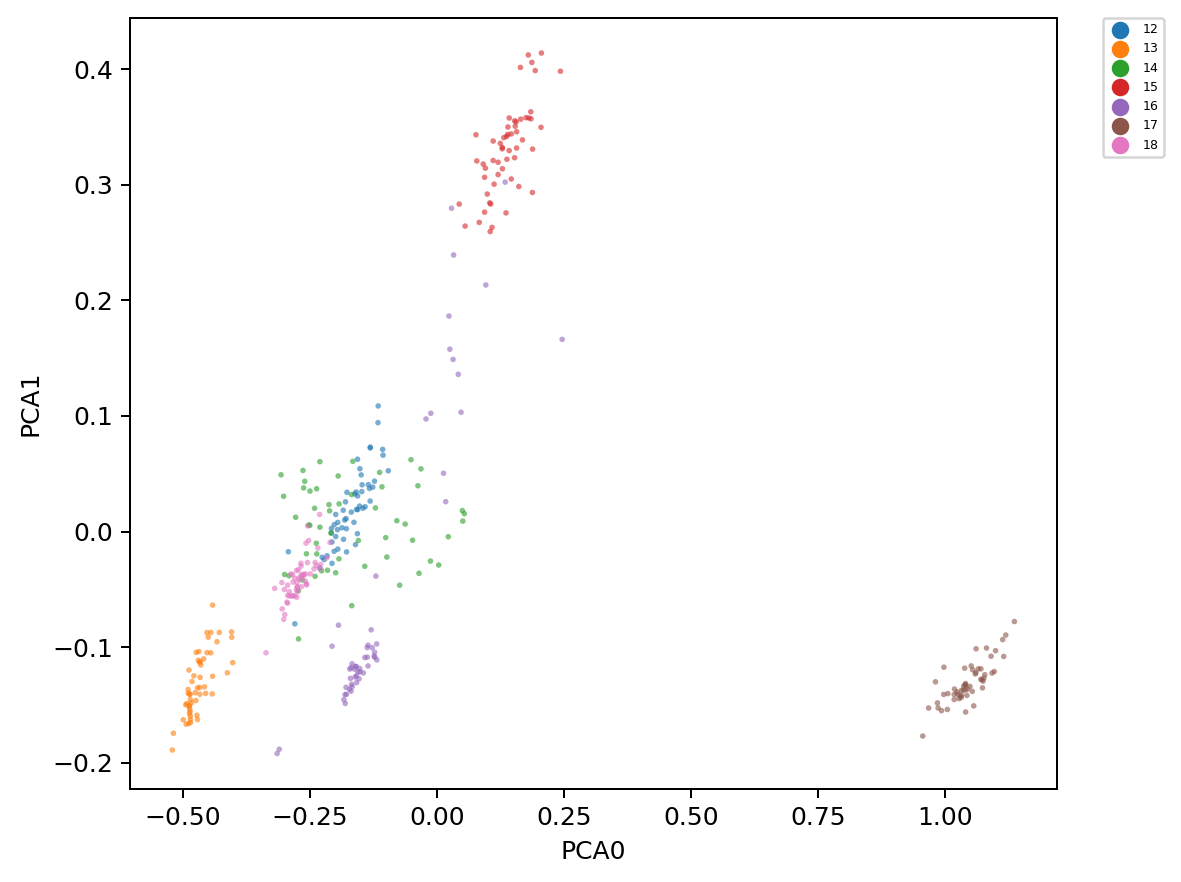

In [204]:
plot_pca(deep_features_valid)


<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

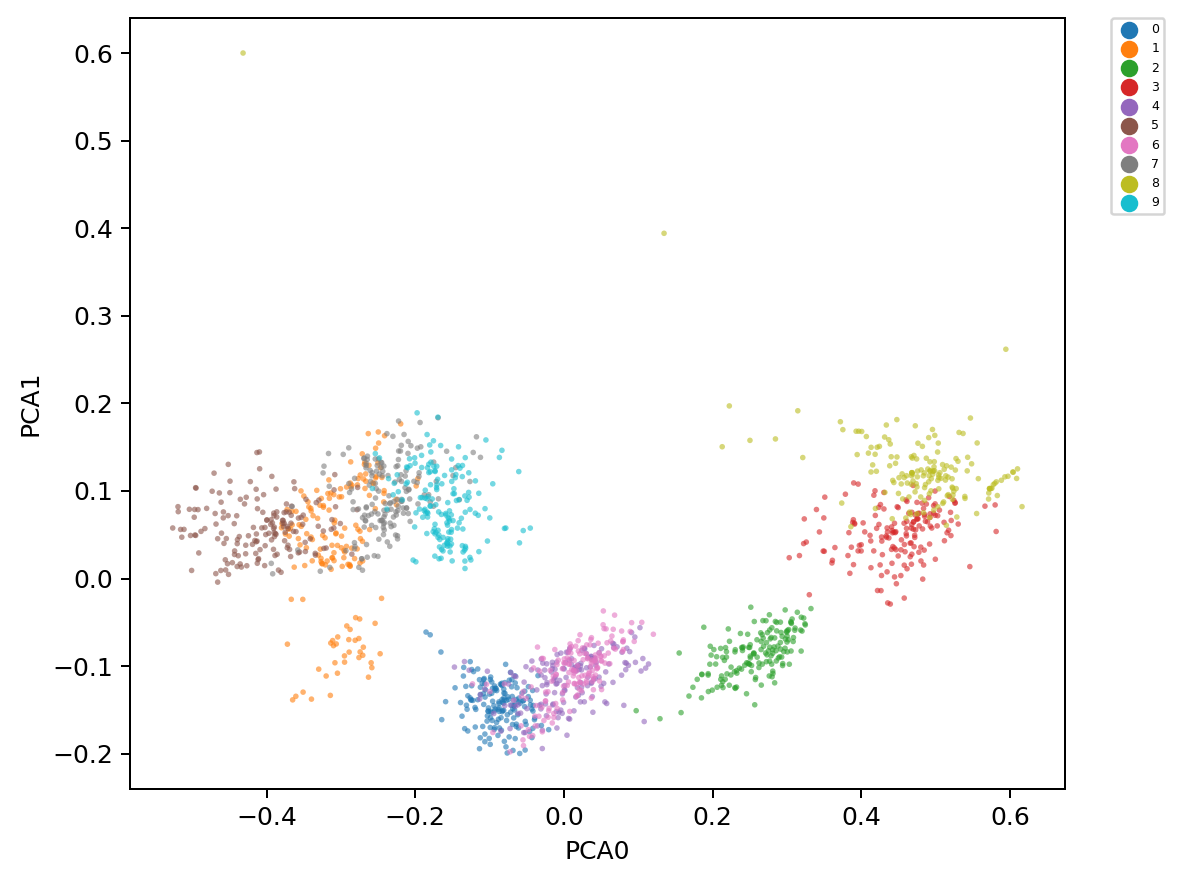

In [194]:
plot_pca(deep_features_test)


In [ ]:
# for i in range(len(train_set)):
#     a = OneClassSVMSets(i, X_exp1_dic,X_exp2_dic)
#     a["X_train"].shape
#     a['X_test_regular'][90, 23]
#     print(np.argwhere(np.isnan(a['X_test_anomalous'])))

In [ ]:
# print(a["X_train"].shape)

In [ ]:
# pca_fs = pca_feature_selector(5)
# pca_fs.add_user_pca(0, pca)
# pca_fs.add_user_pca(1, pca)
# pca_fs.add_user_pca(2, pca)
# pca_fs.add_user_pca(3, pca)
# pca_fs.add_user_pca(4, pca)
# pca_fs.get_comparison_matrix()
# pca_fs.find_top_n_features()
# pca_fs._top_feature_matrix

In [ ]:
n = getIndices2(sampleSize=10, step=2, numSamplePoints= 30)
# n = n % 10
n

In [ ]:
np.bincount(n[:,0])

In [ ]:
np.argmax(np.bincount(n[:,0])[3:])

In [ ]:
np.linspace(0, .5)

In [151]:
np.repeat(1, 10)[None:]


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [66]:
# temp
spliter = 2*len(Raw_X_exp2_test_dic)//3
# spliter = None
OCSVM_train_train = {key: Raw_X_exp2_test_dic[key] for key in list(Raw_X_exp2_test_dic.keys())[:spliter]}
OCSVM_train_valid = {key: Raw_X_exp1_test_dic[key] for key in list(Raw_X_exp1_test_dic.keys())[:spliter]}
OCSVM_test_train = {key: Raw_X_exp2_test_dic[key] for key in list(Raw_X_exp2_test_dic.keys())[spliter:]}
OCSVM_test_test = {key: Raw_X_exp1_test_dic[key] for key in list(Raw_X_exp1_test_dic.keys())[spliter:]}

In [67]:
print(f"train set: {OCSVM_train_train.keys()}\nvalidation set: {OCSVM_train_valid.keys()}")
print(f"test_train set: {OCSVM_test_train.keys()}\ntest_test set: {OCSVM_test_test.keys()}")

train set: dict_keys([0, 1, 2, 3, 4, 5])
validation set: dict_keys([0, 1, 2, 3, 4, 5])
test_train set: dict_keys([6, 7, 8, 9])
test_test set: dict_keys([6, 7, 8, 9])


In [68]:
model.get_layer("basemodel").get_output_at(1)

<KerasTensor: shape=(None, 78) dtype=float32 (created by layer 'basemodel')>

In [69]:
model.layers

In [70]:
# Extract one of the child networks
deep_feature_model = Model(
    inputs=model.layers[0].get_input_at(0),  # get_layer("left_inputs").input,
    outputs=model.get_layer("basemodel").get_output_at(0),
)

In [71]:
deep_feature_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
left_inputs (InputLayer)     [(None, 750, 6)]          0         
_________________________________________________________________
basemodel (Functional)       (None, 78)                21134     
Total params: 21,134
Trainable params: 20,878
Non-trainable params: 256
_________________________________________________________________


In [72]:
deep_feature_model.predict(np.array([OCSVM_train_train[0][0]])).shape

(1, 78)

In [73]:
deep_feature_model.predict(np.array(OCSVM_train_train[0])).shape

(163, 78)

In [74]:
# np.max(b, axis=0)

In [ ]:
# len(OCSVM_train_train[0][0])

In [ ]:
# b.shape

In [ ]:
# a.shape

In [ ]:
# extract_deep_features = lambda X_exp : ExtractDeepFeatures(X_exp, deep_feature_model)

In [ ]:
# extract_deep_features(OCSVM_train_train[0]).shape

In [ ]:
fitted_scaler_ocsvm_exp2_dic.keys()

In [ ]:
OCSVM_train_train[0][0].shape

In [75]:
def MakeDeepXExpDic(X_exp1_train_dic, X_exp2_train_dic, fitted_scaler_ocsvm_exp2_train_dic, X_exp1_test_dic, X_exp2_test_dic, fitted_scaler_ocsvm_exp2_test_dic, deep_feature_model):
    X_exp_train_dic = MakeDeepXExpDicOwner(X_exp2_train_dic, deep_feature_model, scaler_clip=True, scaler_type="MinMaxScaler")
    X_exp_train_dic = MakeDeepXExpDicUnknown(X_exp1_train_dic, deep_feature_model, X_exp_train_dic, fitted_raw_scaler_dict=fitted_scaler_ocsvm_exp2_train_dic)
    X_exp_test_dic = MakeDeepXExpDicOwner(X_exp2_test_dic, deep_feature_model, scaler_clip=True, scaler_type="MinMaxScaler")
    X_exp_test_dic = MakeDeepXExpDicUnknown(X_exp1_test_dic, deep_feature_model, X_exp_test_dic, fitted_raw_scaler_dict=fitted_scaler_ocsvm_exp2_test_dic)
    
    return X_exp_train_dic, X_exp_test_dic

In [76]:
X_exp1_train_dic, X_exp2_train_dic = OCSVM_train_valid, OCSVM_train_train
fitted_scaler_ocsvm_exp2_train_dic = fitted_scaler_ocsvm_exp2_dic
X_exp1_test_dic, X_exp2_test_dic = OCSVM_test_test, OCSVM_test_train
fitted_scaler_ocsvm_exp2_test_dic = fitted_scaler_ocsvm_exp2_dic

In [77]:
# X_exp1_train_dic

In [78]:
warnings.filterwarnings("ignore")
# # temp
print(X_exp1_train_dic.keys())
print(X_exp2_train_dic.keys())
print(X_exp1_test_dic.keys())
print(X_exp2_test_dic.keys())

# X_exp1_train_dic = dict(X_exp1_train_dic, **X_exp1_test_dic)
# X_exp2_train_dic = dict(X_exp2_train_dic, **X_exp2_test_dic)

# print(X_exp1_train_dic.keys())
# print(X_exp2_train_dic.keys())
# # temp
X_exp_train_dic, X_exp_test_dic = \
            MakeDeepXExpDic(X_exp1_train_dic, X_exp2_train_dic, fitted_scaler_ocsvm_exp2_train_dic, X_exp1_test_dic, X_exp2_test_dic, fitted_scaler_ocsvm_exp2_test_dic, deep_feature_model)

dict_keys([0, 1, 2, 3, 4, 5])
dict_keys([0, 1, 2, 3, 4, 5])
dict_keys([6, 7, 8, 9])
dict_keys([6, 7, 8, 9])
raw exp2 samples of owner: 0 are scaled already so we <lambda>
fit_transform <lambda> features using scaler of type: MinMaxScaler, for profile_windows of owner: 0
owner: 0, exp_num: 2, scaler: MinMaxScaler, scaler_clip: True
raw exp2 samples of owner: 1 are scaled already so we <lambda>
fit_transform <lambda> features using scaler of type: MinMaxScaler, for profile_windows of owner: 1
owner: 1, exp_num: 2, scaler: MinMaxScaler, scaler_clip: True
raw exp2 samples of owner: 2 are scaled already so we <lambda>
fit_transform <lambda> features using scaler of type: MinMaxScaler, for profile_windows of owner: 2
owner: 2, exp_num: 2, scaler: MinMaxScaler, scaler_clip: True
raw exp2 samples of owner: 3 are scaled already so we <lambda>
fit_transform <lambda> features using scaler of type: MinMaxScaler, for profile_windows of owner: 3
owner: 3, exp_num: 2, scaler: MinMaxScaler, scaler_cli

In [79]:
# overlap_Mean_EER_df_dict = {.50: None}#{.99: None} #{.90: None, .95: None} #{.80: None, .85: None}#, #{.90: None, .95: None} #0: None, .1: None, .2: None, .3: None, .4: None, .5: None, .6: None, .7: None,
# for overlap in overlap_Mean_EER_df_dict:
#     overlap_Mean_EER_df_dict[overlap] = calculate_EER_different_window_sizes(overlap)

In [80]:
# OCSVM_train_train_deep_features_dic = MakeDeepXExpDic(OCSVM_train_train, deep_feature_model)
# OCSVM_train_valid_deep_features_dic = MakeDeepXExpDic(OCSVM_train_valid, deep_feature_model, fitted_scaler_ocsvm_exp2_dic)
# OCSVM_test_train_deep_features_dic = MakeDeepXExpDic(OCSVM_test_train, deep_feature_model)
# OCSVM_test_test_deep_features_dic = MakeDeepXExpDic(OCSVM_test_test, deep_feature_model, fitted_scaler_ocsvm_exp2_dic)

In [81]:
# print(f"OCSVM_train_train_deep_features_dic[0].shape: {OCSVM_train_train_deep_features_dic[0].shape}")
# print(f"OCSVM_train_valid_deep_features_dic[0].shape: {OCSVM_train_valid_deep_features_dic[0].shape}")
# print(f"len(OCSVM_train_train_deep_features_dic): {len(OCSVM_train_train_deep_features_dic)}")
# print(f"len(OCSVM_train_valid_deep_features_dic): {len(OCSVM_train_valid_deep_features_dic)}")
# print(f"OCSVM_train_train_deep_features_dic.keys(): {OCSVM_train_train_deep_features_dic.keys()}")
# print(f"OCSVM_train_valid_deep_features_dic.keys(): {OCSVM_train_valid_deep_features_dic.keys()}")

In [82]:
# X_exp_dic_sample['X_exp2_dic'][0].shape

In [83]:
# deep_feature_model.predict(OCSVM_train_train[0]).shape

In [84]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_inputs (InputLayer)        [(None, 750, 6)]     0                                            
__________________________________________________________________________________________________
right_inputs (InputLayer)       [(None, 750, 6)]     0                                            
__________________________________________________________________________________________________
basemodel (Functional)          (None, 78)           21134       left_inputs[0][0]                
                                                                 right_inputs[0][0]               
__________________________________________________________________________________________________
distance (Lambda)               (None, 1)            0           basemodel[0][0]            

In [85]:
def evaluate_owner_ocsvm_train_valid(owner_idx, X_exp_train_dic, SEED, run, param_dist, CORES):
    run_seed = SEED + run
    train_dic, valid_test_dic = { owner_idx: X_exp_train_dic[owner_idx]["profile_windows"]}, X_exp_train_dic[owner_idx]["unknown_users_dict"] 
                                #OCSVM_train_train_WACA_features_dic, OCSVM_train_valid_WACA_features_dic
    X_vals_owner_idx = utils_create_cv_splits(owner_idx, train_dic, valid_test_dic, seed=run_seed)

    X_test_regular = X_vals_owner_idx['X_test_regular'].copy()
    X_test_anomalous = X_vals_owner_idx['X_test_anomalous'].copy()

#         print(X_vals_owner_idx['cv_splits'])
    cv_splits = X_vals_owner_idx['cv_splits']

#         pca = PCA(n_components = run)
#         X_train = pca.fit_transform(X_train)
#         X_test_regular = pca.transform(X_test_regular)
#         X_test_anomalous = pca.transform(X_test_anomalous)

#         pca_fs.add_user_pca(owner_idx, pca)

    clf = svm.OneClassSVM(kernel=P.ocsvm_kernel)

    pipeline = Pipeline([
#                             ('scaler', StandardScaler()), 
                        # ('scaler', get_new_scaler_dict[P.scaler]()), 
#                             ('scaler', Normalizer()),
#                              ('pca', pca), 
#                              ('selector', VarianceThreshold()), 
                         ('model', clf)
                        ])

    search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_dist,
        cv=cv_splits,
#             n_iter=120,
        n_iter=80,
#             n_iter=480,
        n_jobs=CORES,
        refit=False,
        scoring={"eer": utils_eer_scorer, "accuracy": "accuracy"},
        verbose=1,
        return_train_score=False,
        # iid=False, #invalid arg in sklearn 1.0.2
        error_score="raise",
        random_state=run_seed
    )
#         search = GridSearchCV(
#             pipeline,
#             param_grid=param_dist,
#             cv=cv_splits,
#             n_jobs=CORES,
#             refit=False,
#             scoring={"eer": utils_eer_scorer, "accuracy": "accuracy"},
#             verbose=1,
#             return_train_score=False,
#             iid=False,
#             error_score="raise",
#         )
#         print(X_train.shape)
#         print(X_test_anomalous.shape)


    search.fit(X_vals_owner_idx['X_train'], X_vals_owner_idx['y_train'])
    impostors = [idx for idx in range(len(train_dic)) if idx != owner_idx]

    df_report = utils_cv_report(search, owner_idx, impostors)
    df_report["run"] = run
    return df_report

In [86]:
X_exp_train_dic.keys()

dict_keys([0, 1, 2, 3, 4, 5])

In [87]:
param_dist = {
    "model__gamma": np.logspace(-3, 1), 
    "model__nu": np.linspace(0.0001, 0.1),
#     'scaler': [StandardScaler(), MinMaxScaler(),
#         Normalizer(), MaxAbsScaler()],
#     "selector__threshold": np.linspace(0, 2, num=1000),

}

import warnings
warnings.filterwarnings("ignore")


df_results = None  # Will be filled with randomsearch scores


# Don't need to loop over to find the best PCA.
for run in tqdm(range(3)):
#     df_results[run] = {}
    
    # for owner_idx in tqdm(
    #     range(len(OCSVM_train_train_deep_features_dic)),
    #     desc="Owner",
    # ):
    df_reports = Parallel(n_jobs=-1)(delayed(evaluate_owner_ocsvm_train_valid)(owner_idx, X_exp_train_dic, SEED, run, param_dist, CORES=1) for owner_idx in range(len(X_exp_train_dic)))
    df_results = pd.concat([df_results] + df_reports, sort=False)
        


df_results

100%|██████████| 3/3 [00:10<00:00,  3.59s/it]


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__nu,param_model__gamma,split0_test_eer,split1_test_eer,split2_test_eer,split3_test_eer,...,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,owner,run,0_test_eer,0_test_accuracy
0,0.002981,0.000190,0.004174,0.000141,0.006216,1.048113,0.487421,0.487421,0.487421,0.487421,...,0.524540,0.524540,0.524540,0.524540,0.000000e+00,52,0,0,NaN,NaN
1,0.003416,0.000007,0.005555,0.000031,0.061263,3.237458,0.500000,0.500000,0.500000,0.500000,...,0.500000,0.500000,0.500000,0.500000,0.000000e+00,61,0,0,NaN,NaN
2,0.002001,0.000006,0.001322,0.000006,0.077573,0.005429,0.128342,0.128342,0.128342,0.128342,...,0.926380,0.926380,0.926380,0.926380,1.110223e-16,21,0,0,NaN,NaN
3,0.003263,0.000002,0.005035,0.000018,0.006216,1.526418,0.495356,0.495356,0.495356,0.495356,...,0.509202,0.509202,0.509202,0.509202,0.000000e+00,58,0,0,NaN,NaN
4,0.003416,0.000012,0.005490,0.000230,0.091845,1.84207,0.500000,0.500000,0.500000,0.500000,...,0.500000,0.500000,0.500000,0.500000,0.000000e+00,61,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.003335,0.000056,0.005286,0.000107,0.018449,2.222996,NaN,0.500000,0.500000,0.500000,...,0.500000,0.500000,0.500000,0.500000,0.000000e+00,60,5,2,0.500000,0.500000
76,0.001839,0.000007,0.001185,0.000013,0.034759,0.004498,NaN,0.370656,0.370656,0.370656,...,0.705521,0.705521,0.705521,0.705521,0.000000e+00,9,5,2,0.370656,0.705521
77,0.003038,0.000035,0.003318,0.000069,0.071457,0.868511,NaN,0.495356,0.495356,0.495356,...,0.509202,0.509202,0.509202,0.509202,0.000000e+00,59,5,2,0.495356,0.509202
78,0.002021,0.000018,0.001446,0.000006,0.1,0.003728,NaN,0.405109,0.405109,0.405109,...,0.659509,0.659509,0.659509,0.659509,0.000000e+00,39,5,2,0.405109,0.659509


In [88]:
len(df_results[df_results["rank_test_eer"] == 1])

21

In [89]:
len(df_results[df_results["owner"] == 14])

0

In [90]:
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# df_results[(df_results.rank_test_eer == 1) & (df_results.rank_test_accuracy == 1)].groupby('owner').head(40)[:269]
df_results[(df_results.rank_test_eer == 1)].groupby('owner').head(232)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__nu,param_model__gamma,split0_test_eer,split1_test_eer,split2_test_eer,split3_test_eer,split4_test_eer,mean_test_eer,std_test_eer,rank_test_eer,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,owner,run,0_test_eer,0_test_accuracy
11,0.001801,0.000011,0.001130,0.000180,0.002139,0.002121,0.057803,0.057803,0.057803,0.061350,0.057803,0.058513,1.418490e-03,1,0.969325,0.969325,0.969325,0.938650,0.969325,0.963190,0.012270,1,0,0,NaN,NaN
16,0.001823,0.000016,0.001137,0.000167,0.01641,0.007906,0.057803,0.057803,0.057803,0.061350,0.057803,0.058513,1.418490e-03,1,0.969325,0.969325,0.969325,0.938650,0.969325,0.963190,0.012270,1,0,0,NaN,NaN
19,0.001793,0.000015,0.001133,0.000175,0.002139,0.006551,0.057803,0.057803,0.057803,0.061350,0.057803,0.058513,1.418490e-03,1,0.969325,0.969325,0.969325,0.938650,0.969325,0.963190,0.012270,1,0,0,NaN,NaN
72,0.001816,0.000006,0.001149,0.000127,0.03272,0.001758,NaN,0.340081,0.340081,0.340081,0.383562,0.348777,1.739227e-02,1,NaN,0.742331,0.742331,0.742331,0.656442,0.725153,0.034356,1,1,0,0.340081,0.742331
56,0.001743,0.000015,0.001069,0.000005,0.004178,0.003089,NaN,0.437931,0.437931,0.437931,0.437931,0.437931,0.000000e+00,1,NaN,0.610429,0.610429,0.610429,0.610429,0.610429,0.000000,1,2,0,0.437931,0.610429
76,0.001796,0.000008,0.001162,0.000011,0.008255,0.075431,NaN,0.368217,0.368217,0.368217,0.368217,0.368217,0.000000e+00,1,NaN,0.708589,0.708589,0.708589,0.708589,0.708589,0.000000,1,3,0,0.368217,0.708589
10,0.001821,0.000011,0.001151,0.000156,0.024565,0.020236,NaN,0.099448,0.099448,0.099448,0.099448,0.101509,4.123433e-03,1,NaN,0.944785,0.944785,0.944785,0.944785,0.934356,0.020859,1,4,0,0.109756,0.892638
11,0.001748,0.000006,0.001094,0.000006,0.002139,0.002121,NaN,0.331967,0.331967,0.331967,0.331967,0.331967,0.000000e+00,1,NaN,0.751534,0.751534,0.751534,0.751534,0.751534,0.000000,1,5,0,0.331967,0.751534
75,0.001752,0.000006,0.001099,0.000169,0.006216,0.007906,0.057803,0.057803,0.057803,0.060976,0.057803,0.058438,1.268857e-03,1,0.969325,0.969325,0.969325,0.941718,0.969325,0.963804,0.011043,1,0,1,NaN,NaN
68,0.001772,0.000013,0.001161,0.000152,0.01641,0.001207,NaN,0.320833,0.320833,0.320833,0.416216,0.340449,3.789793e-02,1,NaN,0.763804,0.763804,0.763804,0.595092,0.728834,0.066913,1,1,1,0.323529,0.757669


In [91]:
display(
    df_results[df_results["rank_test_eer"] == 1]
    .sort_values("mean_test_eer")
    .head(30)
)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__nu,param_model__gamma,split0_test_eer,split1_test_eer,split2_test_eer,split3_test_eer,split4_test_eer,mean_test_eer,std_test_eer,rank_test_eer,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,owner,run,0_test_eer,0_test_accuracy
48,0.001767,0.000013,0.001107,0.000169,0.01641,0.009541,0.057803,0.057803,0.057803,0.060976,0.057803,0.058438,1.268857e-03,1,0.969325,0.969325,0.969325,0.941718,0.969325,0.963804,0.011043,1,0,2,NaN,NaN
75,0.001752,0.000006,0.001099,0.000169,0.006216,0.007906,0.057803,0.057803,0.057803,0.060976,0.057803,0.058438,1.268857e-03,1,0.969325,0.969325,0.969325,0.941718,0.969325,0.963804,0.011043,1,0,1,NaN,NaN
11,0.001801,0.000011,0.001130,0.000180,0.002139,0.002121,0.057803,0.057803,0.057803,0.061350,0.057803,0.058513,1.418490e-03,1,0.969325,0.969325,0.969325,0.938650,0.969325,0.963190,0.012270,1,0,0,NaN,NaN
16,0.001823,0.000016,0.001137,0.000167,0.01641,0.007906,0.057803,0.057803,0.057803,0.061350,0.057803,0.058513,1.418490e-03,1,0.969325,0.969325,0.969325,0.938650,0.969325,0.963190,0.012270,1,0,0,NaN,NaN
19,0.001793,0.000015,0.001133,0.000175,0.002139,0.006551,0.057803,0.057803,0.057803,0.061350,0.057803,0.058513,1.418490e-03,1,0.969325,0.969325,0.969325,0.938650,0.969325,0.963190,0.012270,1,0,0,NaN,NaN
38,0.001814,0.000013,0.001103,0.000083,0.026604,0.013895,NaN,0.089385,0.089385,0.089385,0.089385,0.098567,1.836346e-02,1,NaN,0.950920,0.950920,0.950920,0.950920,0.936810,0.028221,1,4,1,0.135294,0.880368
34,0.001816,0.000013,0.001148,0.000155,0.026604,0.020236,NaN,0.099448,0.099448,0.099448,0.099448,0.101509,4.123433e-03,1,NaN,0.944785,0.944785,0.944785,0.944785,0.934356,0.020859,1,4,2,0.109756,0.892638
10,0.001821,0.000011,0.001151,0.000156,0.024565,0.020236,NaN,0.099448,0.099448,0.099448,0.099448,0.101509,4.123433e-03,1,NaN,0.944785,0.944785,0.944785,0.944785,0.934356,0.020859,1,4,0,0.109756,0.892638
62,0.001750,0.000009,0.001075,0.000014,0.006216,0.001,NaN,0.331967,0.331967,0.331967,0.331967,0.331967,0.000000e+00,1,NaN,0.751534,0.751534,0.751534,0.751534,0.751534,0.000000,1,5,2,0.331967,0.751534
11,0.001748,0.000006,0.001094,0.000006,0.002139,0.002121,NaN,0.331967,0.331967,0.331967,0.331967,0.331967,0.000000e+00,1,NaN,0.751534,0.751534,0.751534,0.751534,0.751534,0.000000,1,5,0,0.331967,0.751534


In [92]:
display(
    df_results[df_results["rank_test_eer"] == 1][
        [
            "mean_fit_time",
            "param_model__nu",
            "param_model__gamma",
            "mean_test_accuracy",
            "std_test_accuracy",
            "mean_test_eer",
            "std_test_eer",
        ]
    ].describe()
)

,mean_fit_time,mean_test_accuracy,std_test_accuracy,mean_test_eer,std_test_eer
count,21.000000,21.000000,21.000000,21.000000,21.000000
mean,0.001787,0.798569,0.013735,0.256001,0.005739
std,0.000034,0.130199,0.019314,0.149722,0.011047
min,0.001743,0.610429,0.000000,0.058438,0.000000
25%,0.001759,0.708589,0.000000,0.098567,0.000000
50%,0.001776,0.748466,0.011043,0.334694,0.001269
75%,0.001816,0.936810,0.020859,0.368217,0.004123
max,0.001867,0.963804,0.066913,0.437931,0.037898


0, −0.40
1, −0.32
2, −0.24
3, −0.16
4, −0.08
['0.320', '0.240', '0.160', '0.080']
0, −0.40
1, −0.32
2, −0.24
3, −0.16
4, −0.08
['0.320', '0.240', '0.160', '0.080']


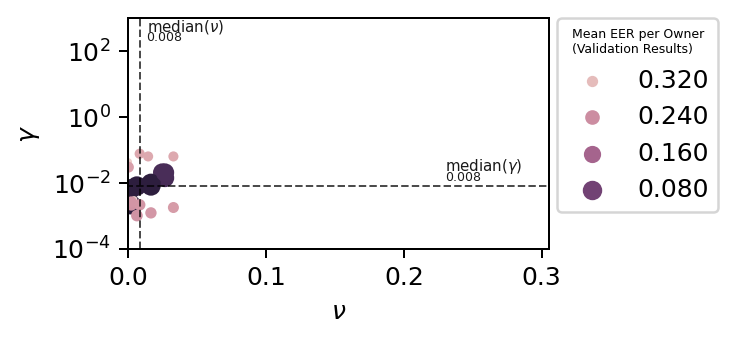

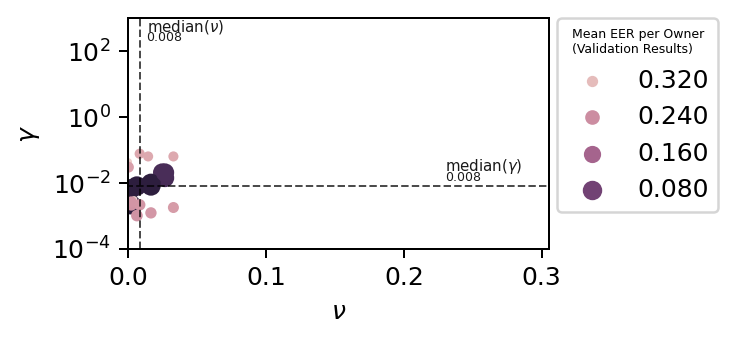

In [93]:
_, _, fig = utils_plot_randomsearch_results(df_results, n_top=1)
P.ocsvm_nu, P.ocsvm_gamma, fig = utils_plot_randomsearch_results(df_results[(df_results.rank_test_eer == 1) & (df_results.mean_test_eer < 0.5)], n_top=1)
plt.savefig(f'SNN-OCSVM-Nu_Gamma_plot-win_size={P.window_size}-step_width={P.ocsvm_step_width}-smoothing:{P.smoothing}.png', bbox_inches='tight')

In [ ]:
# train_df_plot = df_results.rename(
#     columns={"train_accuracy": "train Accuracy", "test_eer": "Test EER", "owner": "Owner"}
# ).astype({"Owner": str})

In [ ]:
# fig = utils_plot_acc_eer_dist(train_df_plot, "Test Accuracy")

In [ ]:
# fig = utils_plot_acc_eer_dist(test_df_plot, "Test Accuracy")

In [ ]:
# k = list(OCSVM_test_train_deep_features_dic.keys())[0]
# print(f"OCSVM_test_train_deep_features_dic[{k}].shape: {OCSVM_test_train_deep_features_dic[k].shape}")
# print(f"OCSVM_test_test_deep_features_dic[{k}].shape: {OCSVM_test_test_deep_features_dic[k].shape}")
# print(f"len(OCSVM_test_train_deep_features_dic): {len(OCSVM_test_train_deep_features_dic)}")
# print(f"len(OCSVM_test_test_deep_features_dic): {len(OCSVM_test_test_deep_features_dic)}")
# print(f"OCSVM_train_train_deep_features_dic.keys(): {OCSVM_test_train_deep_features_dic.keys()}")
# print(f"OCSVM_test_test_deep_features_dic.keys(): {OCSVM_test_test_deep_features_dic.keys()}")

In [ ]:
utils_ppp(P)

In [ ]:
X_exp_test_dic.keys()

In [94]:
test_df_results = None  # Will be filled with randomsearch scores
for run in tqdm(range(5)):


    for owner_idx in tqdm(
        X_exp_test_dic.keys(),
        desc="Owner",
    ):

        
        run_seed = SEED + run
        train_dic, valid_test_dic = { owner_idx: X_exp_test_dic[owner_idx]["profile_windows"]}, X_exp_test_dic[owner_idx]["unknown_users_dict"] 
        X_vals_owner_idx = utils_create_cv_splits(owner_idx, train_dic, valid_test_dic, seed=run_seed)
#         X_train = X_vals_owner_idx['X_train']
#          = X.reshape(X.shape[-3], -1)  # flatten windows
        X_test_regular = X_vals_owner_idx['X_test_regular']
        X_test_anomalous = X_vals_owner_idx['X_test_anomalous']
#         print(X_vals_owner_idx)
#         break
#         np.random.shuffle(X_train)
#         np.random.shuffle(X_test_regular)
#         np.random.shuffle(X_test_anomalous)
#         print(X_vals_owner_idx['cv_splits'])
        train_test_cv_splits = X_vals_owner_idx['cv_splits']
        
        
#         pca = PCA(n_components = run)
#         X_train = pca.fit_transform(X_train)
#         X_test_regular = pca.transform(X_test_regular)
#         X_test_anomalous = pca.transform(X_test_anomalous)
        
        clf = svm.OneClassSVM(kernel=P.ocsvm_kernel, nu=P.ocsvm_nu, gamma=P.ocsvm_gamma)
        pipeline = Pipeline([
#             Normalizer, MaxAbsScaler,
            # ('scaler', get_new_scaler_dict["RobustScaler"]()), 
#                             ('scaler', StandardScaler()), 
#                              ('scaler', RobustScaler()),
#                              ('scaler', MaxAbsScaler()),
#                             ('scaler', Normalizer()),#best result
#                             ('scaler', PowerTransformer()),
#                              ('pca', pca), 
#                              ('selector', VarianceThreshold()), 
                             ('model', clf)
                            ])
        
        scores = cross_validate(
            pipeline,
            X_vals_owner_idx['X_train'],
            X_vals_owner_idx['y_train'],
            cv=train_test_cv_splits,
            scoring={
                "eer": utils_eer_scorer,
                "accuracy": "accuracy",
                "precision": "precision",
                "recall": "recall",
            },
            n_jobs=CORES,
            verbose=1,
            return_train_score=True,
        )
        
        df_score = pd.DataFrame(scores)
        df_score["owner"] = owner_idx
        df_score["train_eer"] = df_score["train_eer"].abs()  # Revert scorer's signflip
        df_score["test_eer"] = df_score["test_eer"].abs()
        test_df_results = pd.concat([test_df_results, df_score], axis=0)
        

test_df_results.head()

Owner:   0%|          | 0/4 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


owner: 6 train_idx range: 0, 162
owner: 6 valid_idx range: 163, 325
imposter: 7 valid_idx range: 326, 488
imposter: 8 valid_idx range: 489, 651
imposter: 9 valid_idx range: 652, 814


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:990: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:990: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:990: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished

Owner:  25%|██▌       | 1/4 [00:00<00:00,  3.78it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


owner: 7 train_idx range: 0, 162
owner: 7 valid_idx range: 163, 325
imposter: 6 valid_idx range: 326, 488
imposter: 8 valid_idx range: 489, 651
imposter: 9 valid_idx range: 652, 814


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:990: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:990: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:990: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished

Owner:  50%|█████     | 2/4 [00:00<00:00,  3.77it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:990: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/metr

owner: 8 train_idx range: 0, 162
owner: 8 valid_idx range: 163, 325
imposter: 6 valid_idx range: 326, 488
imposter: 7 valid_idx range: 489, 651
imposter: 9 valid_idx range: 652, 814
owner: 9 train_idx range: 0, 162
owner: 9 valid_idx range: 163, 325
imposter: 6 valid_idx range: 326, 488
imposter: 7 valid_idx range: 489, 651
imposter: 8 valid_idx range: 652, 814



Owner:   0%|          | 0/4 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:990: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:990: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:990: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:990: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless

owner: 6 train_idx range: 0, 162
owner: 6 valid_idx range: 163, 325
imposter: 7 valid_idx range: 326, 488
imposter: 8 valid_idx range: 489, 651
imposter: 9 valid_idx range: 652, 814
owner: 7 train_idx range: 0, 162
owner: 7 valid_idx range: 163, 325
imposter: 6 valid_idx range: 326, 488
imposter: 8 valid_idx range: 489, 651
imposter: 9 valid_idx range: 652, 814
owner: 8 train_idx range: 0, 162
owner: 8 valid_idx range: 163, 325
imposter: 6 valid_idx range: 326, 488
imposter: 7 valid_idx range: 489, 651
imposter: 9 valid_idx range: 652, 814
owner: 9 train_idx range: 0, 162
owner: 9 valid_idx range: 163, 325
imposter: 6 valid_idx range: 326, 488
imposter: 7 valid_idx range: 489, 651
imposter: 8 valid_idx range: 652, 814



Owner:   0%|          | 0/4 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:990: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:990: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:990: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:990: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless

owner: 6 train_idx range: 0, 162
owner: 6 valid_idx range: 163, 325
imposter: 7 valid_idx range: 326, 488
imposter: 8 valid_idx range: 489, 651
imposter: 9 valid_idx range: 652, 814
owner: 7 train_idx range: 0, 162
owner: 7 valid_idx range: 163, 325
imposter: 6 valid_idx range: 326, 488
imposter: 8 valid_idx range: 489, 651
imposter: 9 valid_idx range: 652, 814
owner: 8 train_idx range: 0, 162
owner: 8 valid_idx range: 163, 325
imposter: 6 valid_idx range: 326, 488
imposter: 7 valid_idx range: 489, 651
imposter: 9 valid_idx range: 652, 814
owner: 9 train_idx range: 0, 162
owner: 9 valid_idx range: 163, 325
imposter: 6 valid_idx range: 326, 488
imposter: 7 valid_idx range: 489, 651
imposter: 8 valid_idx range: 652, 814


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:990: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:990: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:990: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
Owner:   0%|          | 0/4 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:990: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_rank

owner: 6 train_idx range: 0, 162
owner: 6 valid_idx range: 163, 325
imposter: 7 valid_idx range: 326, 488
imposter: 8 valid_idx range: 489, 651
imposter: 9 valid_idx range: 652, 814
owner: 7 train_idx range: 0, 162
owner: 7 valid_idx range: 163, 325
imposter: 6 valid_idx range: 326, 488
imposter: 8 valid_idx range: 489, 651
imposter: 9 valid_idx range: 652, 814


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:990: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:990: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:990: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:990: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:990: UndefinedMetricWarning: No negat

owner: 8 train_idx range: 0, 162
owner: 8 valid_idx range: 163, 325
imposter: 6 valid_idx range: 326, 488
imposter: 7 valid_idx range: 489, 651
imposter: 9 valid_idx range: 652, 814
owner: 9 train_idx range: 0, 162
owner: 9 valid_idx range: 163, 325
imposter: 6 valid_idx range: 326, 488
imposter: 7 valid_idx range: 489, 651
imposter: 8 valid_idx range: 652, 814



Owner:   0%|          | 0/4 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:990: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:990: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:990: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:990: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless

owner: 6 train_idx range: 0, 162
owner: 6 valid_idx range: 163, 325
imposter: 7 valid_idx range: 326, 488
imposter: 8 valid_idx range: 489, 651
imposter: 9 valid_idx range: 652, 814
owner: 7 train_idx range: 0, 162
owner: 7 valid_idx range: 163, 325
imposter: 6 valid_idx range: 326, 488
imposter: 8 valid_idx range: 489, 651
imposter: 9 valid_idx range: 652, 814


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:990: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:990: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:990: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:990: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:990: UndefinedMetricWarning: No negat

owner: 8 train_idx range: 0, 162
owner: 8 valid_idx range: 163, 325
imposter: 6 valid_idx range: 326, 488
imposter: 7 valid_idx range: 489, 651
imposter: 9 valid_idx range: 652, 814
owner: 9 train_idx range: 0, 162
owner: 9 valid_idx range: 163, 325
imposter: 6 valid_idx range: 326, 488
imposter: 7 valid_idx range: 489, 651
imposter: 8 valid_idx range: 652, 814


,fit_time,score_time,test_eer,train_eer,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,owner
0,0.002194,0.002799,0.099448,1.818989e-12,0.944785,0.987730,1.0,1.0,0.889571,0.987730,6
1,0.002204,0.002812,0.099448,1.818989e-12,0.944785,0.987730,1.0,1.0,0.889571,0.987730,6
2,0.002206,0.002832,0.099448,1.818989e-12,0.944785,0.987730,1.0,1.0,0.889571,0.987730,6
0,0.002230,0.002856,0.297414,1.818989e-12,0.788344,0.981595,1.0,1.0,0.576687,0.981595,7
1,0.002170,0.002857,0.297414,1.818989e-12,0.788344,0.981595,1.0,1.0,0.576687,0.981595,7


In [95]:
test_df_plot = test_df_results.rename(
    columns={"test_accuracy": "Test Accuracy", "test_eer": "Test EER", "owner": "Owner"}
).astype({"Owner": str})

Overall mean: 0.8652


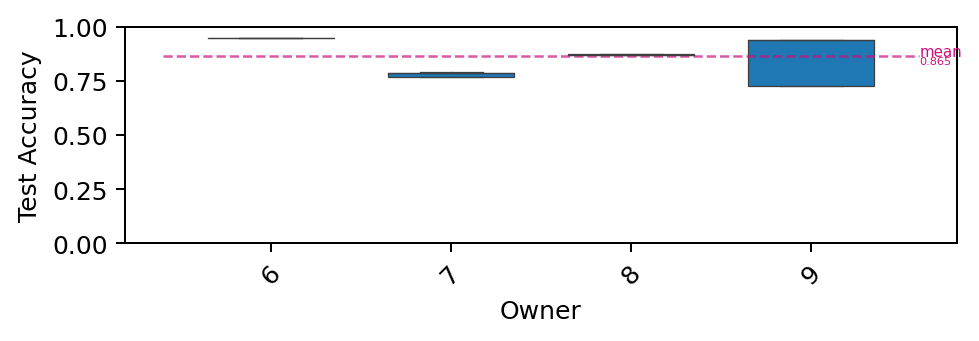

In [96]:
fig = utils_plot_acc_eer_dist(test_df_plot, "Test Accuracy")
plt.savefig(f'CNN-OCSVM-{P.model_variant}-Accuray-win_size={P.window_size}-step_width={P.nn_step_width}-epochs:{P.epochs_best}-smoothing:{P.smoothing}.png', bbox_inches='tight')

Overall mean: 0.1979


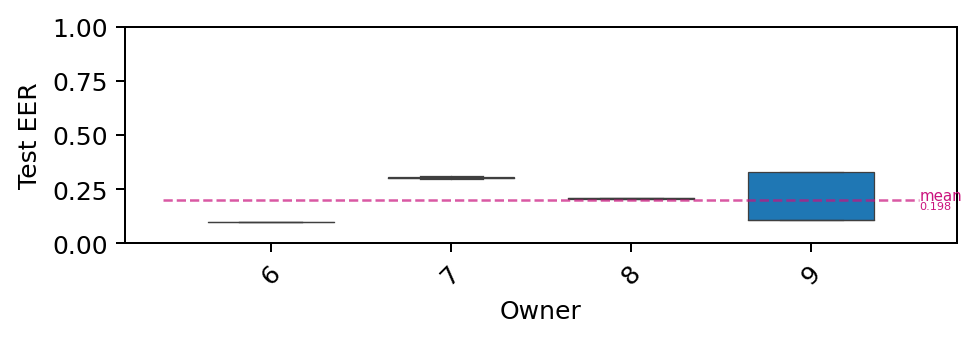

owner: 3 train_idx range: 0, 162
owner: 3 valid_idx range: 163, 325
imposter: 0 valid_idx range: 326, 488
imposter: 1 valid_idx range: 489, 651
imposter: 2 valid_idx range: 652, 814
imposter: 4 valid_idx range: 815, 977
imposter: 5 valid_idx range: 978, 1140
Fitting 5 folds for each of 80 candidates, totalling 400 fits
idx: 0, impostor: 0
owner: 4 train_idx range: 0, 162
owner: 4 valid_idx range: 163, 325
imposter: 0 valid_idx range: 326, 488
imposter: 1 valid_idx range: 489, 651
imposter: 2 valid_idx range: 652, 814
imposter: 3 valid_idx range: 815, 977
imposter: 5 valid_idx range: 978, 1140
Fitting 5 folds for each of 80 candidates, totalling 400 fits
idx: 0, impostor: 0
owner: 5 train_idx range: 0, 162
owner: 5 valid_idx range: 163, 325
imposter: 0 valid_idx range: 326, 488
imposter: 1 valid_idx range: 489, 651
imposter: 2 valid_idx range: 652, 814
imposter: 3 valid_idx range: 815, 977
imposter: 4 valid_idx range: 978, 1140
Fitting 5 folds for each of 80 candidates, totalling 400 fi

In [97]:
fig = utils_plot_acc_eer_dist(test_df_plot, "Test EER")
plt.savefig(f'CNN-OCSVM-{P.model_variant}-EER-win_size={P.window_size}-step_width={P.nn_step_width}-epochs:{P.epochs_best}-smoothing:{P.smoothing}.png', bbox_inches='tight')

In [ ]:
utils_ppp(P)

In [ ]:
test_df_results.shape